<font size="5"><center> **Exercise 2 <br>
(Conditional RealNVP on MNIST).** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [22]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-8

In [7]:
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Uniform
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import os

seed = 42
tc.manual_seed(42)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using --> {device}")

Using --> cuda


<font size="3">The following code is essentially the same as the one from the previous exercise (EX1_CS673.ipynb), with the primary difference being that the network is now conditioned on the digit labels of the MNIST dataset. <br>This conditioning allows the model to incorporate additional information about the digit classes, potentially improving its ability to generate and interpolate between specific digit images.

→ (a): Add digit information to the RealNVP model and learn the conditional distributions.

The equation for the conditional RealNVP model is given by:

$$
\begin{pmatrix}
x_A \\
x_B
\end{pmatrix}
=
\begin{pmatrix}
z_A \\
z_B \odot e^{\alpha_\theta(z_A, y)} + m_\theta(z_A, y)
\end{pmatrix}
$$

where $ y \in \mathbb{R}^{10} $ corresponds to the one-hot encoding vector of the MNIST digit labels.

In this conditional model:
- Everything regarding the symbols remains the same.
- $ \alpha_\theta(z_A, y) $ is the scaling function, parameterized by $\theta$, which now takes both $ z_A $ and the one-hot encoded label $ y $ as inputs.
- $ m_\theta(z_A, y) $ is the translation function, also parameterized by $\theta$, which similarly takes $ z_A $ and $ y $ as inputs.

By conditioning on the one-hot encoded labels $ y $, the model learns to generate and interpolate digit images conditioned on specific digit classes, thereby improving its ability to understand and generate MNIST digit images.


↓ Conditioned CouplingLayer Class ↓

The `RealNVPCouplingLayer` class conditions the transformations on the MNIST labels by concatenating the one-hot encoded labels with the input data.<br> 
During both the `forward` and `inverse` passes, the input is split using binary masks, concatenated with the labels, and passed through scale and translation subnetworks to apply the transformations.<br>
The `ScalingLayer` class globally scales the data, computing the log-determinant of the Jacobian for the scaling transformation (same as before). 

In [8]:
# Generates an alternating binary mask of given dimension
def get_mask(dim, orientation=True):
    return ((1 - tc.arange(dim) % 2) ^ orientation).float()

class RealNVPCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask, n_layers=4, label_dim=10):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.label_dim = label_dim

        self.odd_mask = mask
        self.even_mask = 1 - self.odd_mask

        self.scale_net = self._build_subnet(input_dim, hidden_dim, n_layers, label_dim)
        self.translation_net = self._build_subnet(input_dim, hidden_dim, n_layers, label_dim)

    def _build_subnet(self, input_dim, hidden_dim, n_layers, label_dim):
        modules = [nn.Linear(input_dim + label_dim, hidden_dim), nn.LeakyReLU(0.15)]

        for _ in range(n_layers - 2):
            modules.append(nn.Linear(hidden_dim, hidden_dim))
            modules.append(nn.ReLU(0.15))
        modules.append(nn.Linear(hidden_dim, input_dim))

        return nn.Sequential(*modules)

    def forward(self, x, labels):
        x1 = self.odd_mask * x
        x2 = self.even_mask * x
        # concatenate x1 with the one-hot encoded digit labels
        x1_concat = tc.cat([x1, labels], dim=1)

        # bound the output of the scale network within a range of [−1,1]
        scale = tc.exp(tc.tanh(self.scale_net(x1_concat))) # αθ(x1) 

        # even_mask is applied to translation component to ensure transformations
        # are applied to masked elements. scale inherently applies to masked input by multiplication
        translation = self.translation_net(x1_concat) * self.even_mask # mθ(x1)

        y1 = x1
        y2 = x2 * scale + translation

        return y1 + y2

    def inverse(self, y, labels):
        y1 = self.odd_mask * y
        y2 = self.even_mask * y
        # concatenate y1 with the one-hot encoded digit labels
        y1_concat = tc.cat([y1, labels], dim=1)

        scale = tc.exp(-tc.tanh(self.scale_net(y1_concat))) # αθ(y1) 
        translation = self.translation_net(y1_concat) * self.even_mask # mθ(y1)

        x1 = y1
        x2 = (y2 - translation) * scale

        return x1 + x2

# The ScalingLayer applies a global scaling transformation to the data 
# and computes the log-determinant of the Jacobian, used to calculate 
# the log-likelihood. It is used separately from the coupling layers.
class ScalingLayer(nn.Module):
    def __init__(self, inpt_dim):
        super().__init__()
        self.log_scale_vector = nn.Parameter(tc.zeros(1, inpt_dim, requires_grad=True))

    def forward(self, x):
        log_det_jacobian = tc.sum(self.log_scale_vector)
        scaled_x = tc.exp(self.log_scale_vector) * x
        return scaled_x, log_det_jacobian

    def inverse(self, x):
        return tc.exp(-self.log_scale_vector) * x

↓ Conditional RealNVP ↓

<font size = '3'>The key conditional component is `x1_concat = tc.cat([x1, labels], dim=1)`, which concatenates the masked input with the one-hot encoded labels

In [9]:
# Distribution base class for log probability and sampling
class Distribution(ABC):
    @abstractmethod
    def log_prob(self, x):
        pass

    @abstractmethod
    def sample(self, size):
        pass

# LogisticDistribution class for computing log prob and sampling
class LogisticDistribution(Distribution):
    def __init__(self):
        super().__init__()
        self.uniform_dist = Uniform(tc.tensor([0.0]), tc.tensor([1.0]))

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = self.uniform_dist.sample(size)
        return tc.log(z) - tc.log(1. - z)

# RealNVP Conditioned class implementing the main model:
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_coupling_layers, n_layers, label_dim=10):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_coupling_layers = n_coupling_layers
        self.num_layers = n_layers
        self.label_dim = label_dim
        self.prior = LogisticDistribution()

        masks = [
            get_mask(input_dim, orientation=(i % 2 == 0)).to(device)
            for i in range(n_coupling_layers)
        ]

        self.coupling_layers = nn.ModuleList([
            RealNVPCouplingLayer(
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                mask=masks[i],
                n_layers=n_layers,
                label_dim=label_dim
            )
            for i in range(n_coupling_layers)
        ])
        self.scaling_layer = ScalingLayer(inpt_dim=input_dim)

    def forward(self, x, labels):
        y = x
        for i in range(len(self.coupling_layers)):
            y = self.coupling_layers[i](y, labels)
        y, log_det_jacobian = self.scaling_layer(y)
        log_likel = tc.sum(self.prior.log_prob(y), dim=1) + log_det_jacobian
        return y, log_likel

    def inverse(self, y, labels):
        x = y
        x = self.scaling_layer.inverse(x)
        for i in reversed(range(len(self.coupling_layers))):
            x = self.coupling_layers[i].inverse(x, labels)
        return x

    def sample(self, num_samples, labels):
        y = self.prior.sample([num_samples, self.input_dim]).view(num_samples, self.input_dim).to(device)
        return self.inverse(y, labels)

↓ Dequantize and Scale images ↓

In [10]:
# add uniform noise to dequantize images and scales them to a specified range, 
# clamping the values between 0 and 1.
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        img += tc.rand_like(img) / 256.0
        img *= (self.max_val - self.min_val) + self.min_val
        return img.clamp(0, 1)

↓ Trains the RealNVP Conditioned model ↓

In [11]:
def train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                  checkpoint_folder = 'checkpoints', checkpoint_name = 'best_model.pth'):

    os.makedirs(checkpoint_folder, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_name)

    model.train()
    optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    losses_ = np.zeros(epochs)
    best_loss = float('inf') # for the saving

    for epoch in range(epochs):
        model.train()
        tot_mean_nll = 0.0

        for batch_id, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Zero gradients:
            model.zero_grad()
            # Move to device and flatten:
            x = x.to(device).view(-1, input_dim)
            # converts the integer digit labels into one-hot encoded vectors
            y = F.one_hot(y, num_classes=10).float().to(device)
            # Call model:
            _, log_likelihood = model(x, y)
            # Compute mean NLL loss:
            loss = -tc.mean(log_likelihood)
            # Backpropagate:
            loss.backward()
            # Gradient clipping:
            tc.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            # Update weights:
            optimizer.step()
            # Add loss:
            tot_mean_nll += loss.item()

        # Take the mean over each epoch and print:
        mean_nll = tot_mean_nll / len(train_loader)
        losses_[epoch] = mean_nll
        print(f'Epoch {epoch+1}/{epochs} | Mean NLL (Loss): {mean_nll:.4f}')

        ######### SAVE BEST MODEL #########
        if mean_nll < best_loss:
            best_loss = mean_nll
            best_epoch = epoch + 1
            tc.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'losses': losses_
            }, checkpoint_path)
        ###################################

        if (epoch + 1) % 5 == 0:
            sample_model(model, n_samples=10, title=f"Epoch {epoch + 1}")

        scheduler.step()  # Step the scheduler at the end of each epoch

    return losses_

# Generates and visualizes samples from the trained model conditioned for every digit
def sample_model(model, n_samples=10, title="None"):
    model.eval()
    # Generate one-hot labels for digits 0 to 9
    labels = tc.eye(10).to(device)  
    x_hat = model.sample(n_samples, labels)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, 28, 28)
    n_rows, n_cols = 2, 5  
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(10, 4),  
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, ax in enumerate(axs.flat[:n_samples]):
        ax.imshow(x_hat[i], cmap='gray_r')
        ax.set_title(f"Digit: {i}", fontsize=12)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

→ (b): Train RealNVP for 5 and 10 coupling-layers

100%|██████████| 469/469 [00:12<00:00, 36.92it/s]


Epoch 1/100 | Mean NLL (Loss): 910.0478


100%|██████████| 469/469 [00:11<00:00, 39.09it/s]


Epoch 2/100 | Mean NLL (Loss): 542.4592


100%|██████████| 469/469 [00:11<00:00, 40.48it/s]


Epoch 3/100 | Mean NLL (Loss): 176.2612


100%|██████████| 469/469 [00:11<00:00, 39.67it/s]


Epoch 4/100 | Mean NLL (Loss): -189.3368


100%|██████████| 469/469 [00:21<00:00, 21.91it/s]


Epoch 5/100 | Mean NLL (Loss): -553.7675


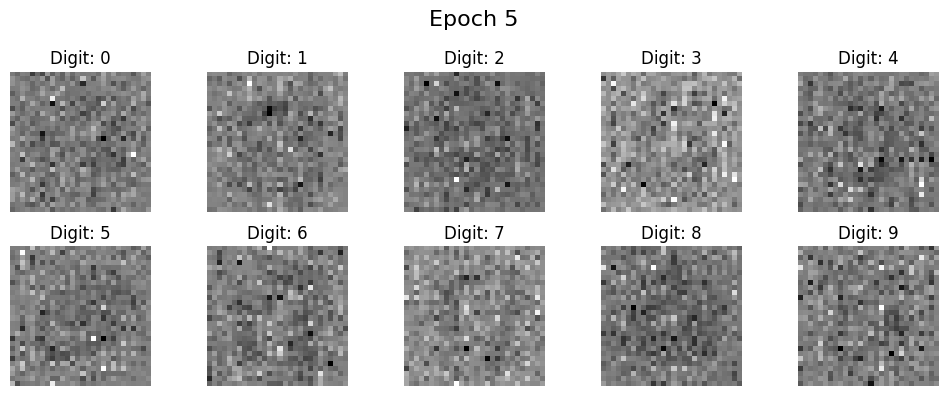

100%|██████████| 469/469 [00:24<00:00, 19.51it/s]


Epoch 6/100 | Mean NLL (Loss): -915.9285


100%|██████████| 469/469 [00:24<00:00, 19.51it/s]


Epoch 7/100 | Mean NLL (Loss): -1270.6816


100%|██████████| 469/469 [00:23<00:00, 20.06it/s]


Epoch 8/100 | Mean NLL (Loss): -1603.0466


100%|██████████| 469/469 [00:24<00:00, 19.44it/s]


Epoch 9/100 | Mean NLL (Loss): -1892.9325


100%|██████████| 469/469 [00:23<00:00, 19.59it/s]


Epoch 10/100 | Mean NLL (Loss): -2124.8858


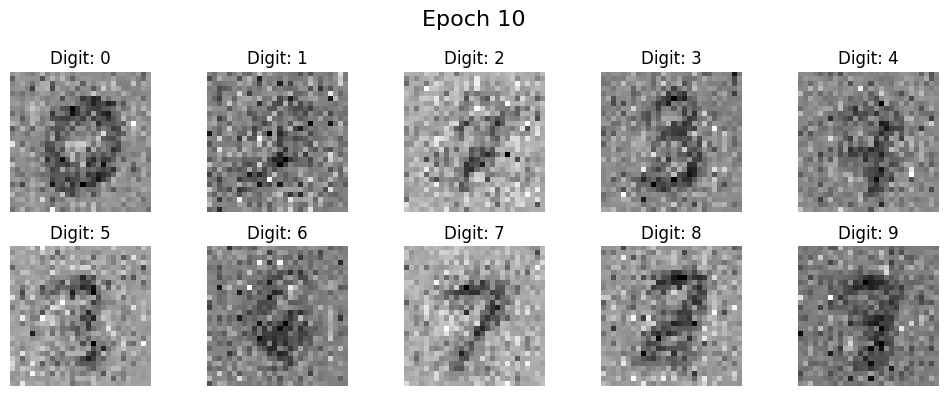

100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Epoch 11/100 | Mean NLL (Loss): -2323.8348


100%|██████████| 469/469 [00:23<00:00, 19.72it/s]


Epoch 12/100 | Mean NLL (Loss): -2419.3901


100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Epoch 13/100 | Mean NLL (Loss): -2497.9087


100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


Epoch 14/100 | Mean NLL (Loss): -2561.7473


100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


Epoch 15/100 | Mean NLL (Loss): -2608.7056


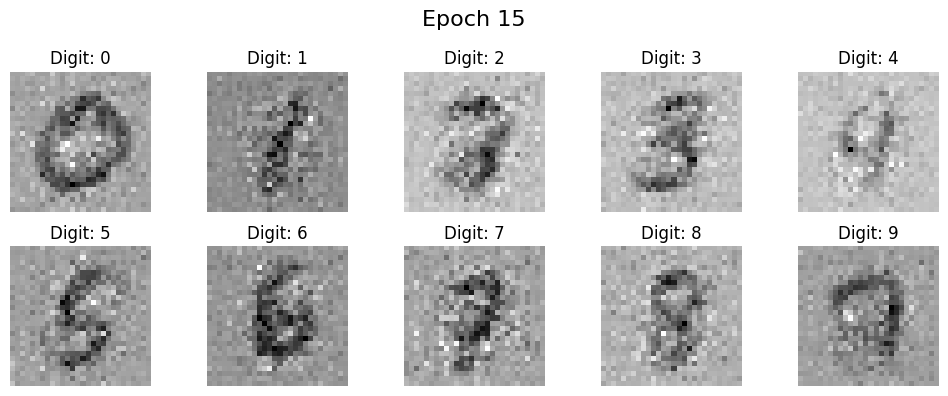

100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Epoch 16/100 | Mean NLL (Loss): -2647.6222


100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


Epoch 17/100 | Mean NLL (Loss): -2669.8238


100%|██████████| 469/469 [00:11<00:00, 40.87it/s]


Epoch 18/100 | Mean NLL (Loss): -2686.7566


100%|██████████| 469/469 [00:11<00:00, 39.74it/s]


Epoch 19/100 | Mean NLL (Loss): -2692.6886


100%|██████████| 469/469 [00:12<00:00, 38.59it/s]


Epoch 20/100 | Mean NLL (Loss): -2704.6886


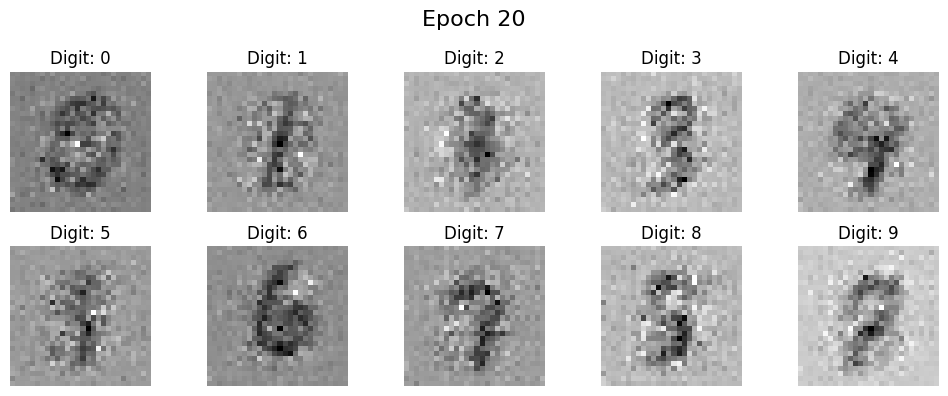

100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Epoch 21/100 | Mean NLL (Loss): -2834.9860


100%|██████████| 469/469 [00:14<00:00, 32.43it/s]


Epoch 22/100 | Mean NLL (Loss): -2857.9232


100%|██████████| 469/469 [00:24<00:00, 18.95it/s]


Epoch 23/100 | Mean NLL (Loss): -2874.5982


100%|██████████| 469/469 [00:24<00:00, 18.92it/s]


Epoch 24/100 | Mean NLL (Loss): -2885.3611


100%|██████████| 469/469 [00:24<00:00, 19.45it/s]


Epoch 25/100 | Mean NLL (Loss): -2894.1591


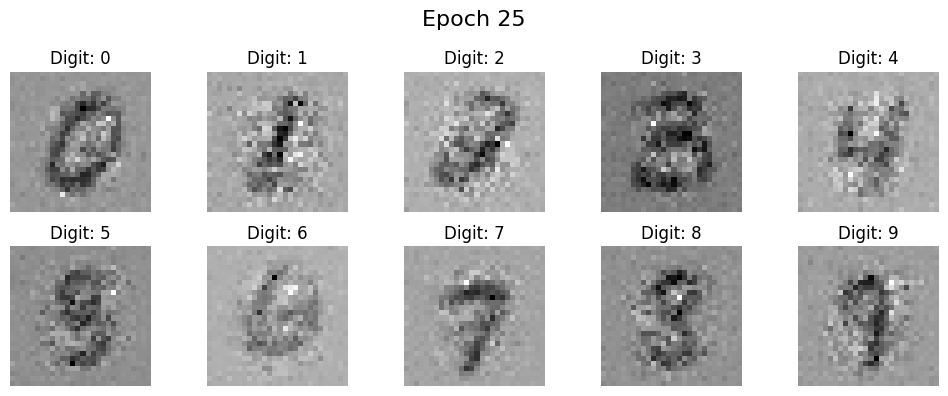

100%|██████████| 469/469 [00:23<00:00, 19.56it/s]


Epoch 26/100 | Mean NLL (Loss): -2905.1278


100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Epoch 27/100 | Mean NLL (Loss): -2912.3238


100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Epoch 28/100 | Mean NLL (Loss): -2920.6458


100%|██████████| 469/469 [00:19<00:00, 24.05it/s]


Epoch 29/100 | Mean NLL (Loss): -2921.7589


100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


Epoch 30/100 | Mean NLL (Loss): -2929.4611


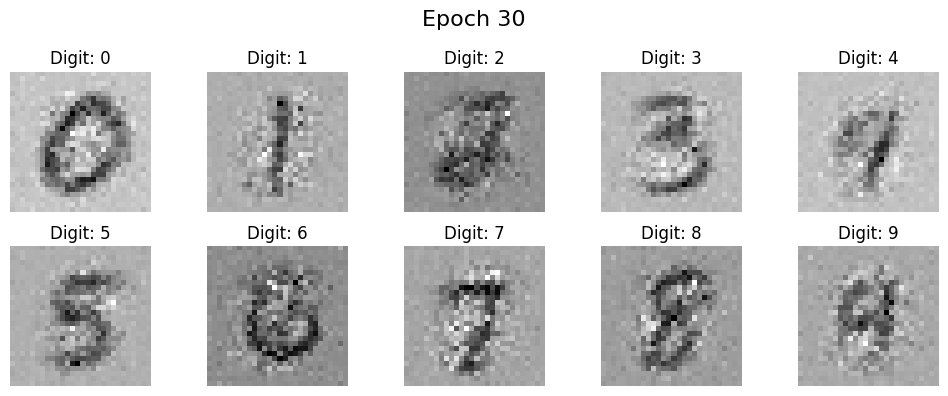

100%|██████████| 469/469 [00:25<00:00, 18.60it/s]


Epoch 31/100 | Mean NLL (Loss): -3020.4133


100%|██████████| 469/469 [00:25<00:00, 18.68it/s]


Epoch 32/100 | Mean NLL (Loss): -3031.6600


100%|██████████| 469/469 [00:24<00:00, 19.28it/s]


Epoch 33/100 | Mean NLL (Loss): -3040.8045


100%|██████████| 469/469 [00:17<00:00, 27.21it/s]


Epoch 34/100 | Mean NLL (Loss): -3046.4638


100%|██████████| 469/469 [00:12<00:00, 38.35it/s]


Epoch 35/100 | Mean NLL (Loss): -3055.8847


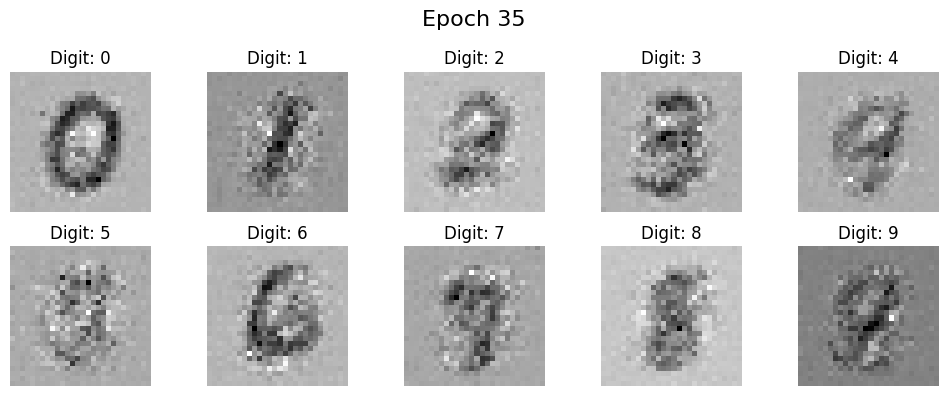

100%|██████████| 469/469 [00:21<00:00, 22.29it/s]


Epoch 36/100 | Mean NLL (Loss): -3063.0240


100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Epoch 37/100 | Mean NLL (Loss): -3069.1713


100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Epoch 38/100 | Mean NLL (Loss): -3073.7857


100%|██████████| 469/469 [00:24<00:00, 19.16it/s]


Epoch 39/100 | Mean NLL (Loss): -3079.8044


100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


Epoch 40/100 | Mean NLL (Loss): -3085.2314


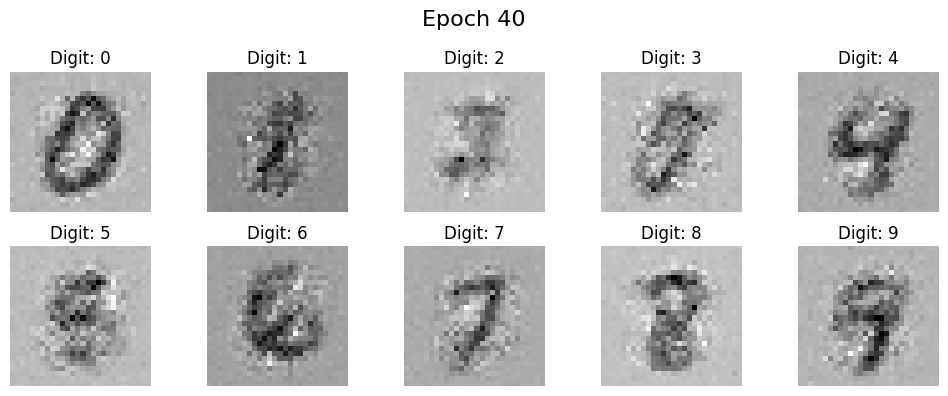

100%|██████████| 469/469 [00:24<00:00, 19.54it/s]


Epoch 41/100 | Mean NLL (Loss): -3133.8369


100%|██████████| 469/469 [00:24<00:00, 19.02it/s]


Epoch 42/100 | Mean NLL (Loss): -3141.6071


100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 43/100 | Mean NLL (Loss): -3146.5222


100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Epoch 44/100 | Mean NLL (Loss): -3151.5281


100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 45/100 | Mean NLL (Loss): -3157.0615


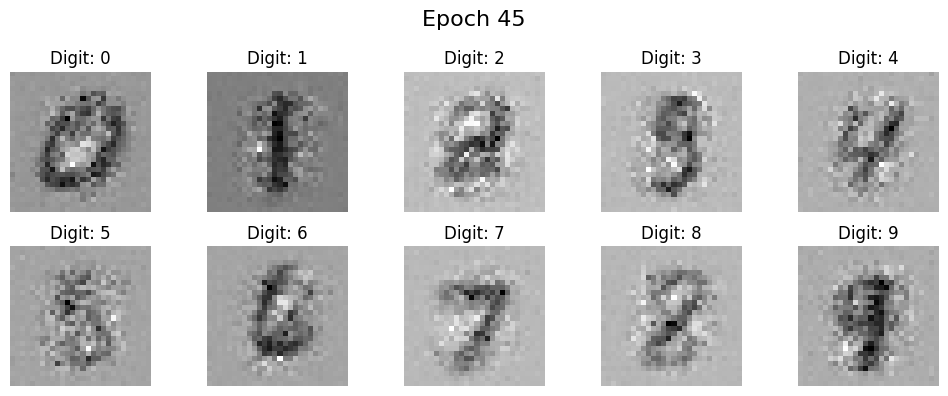

100%|██████████| 469/469 [00:24<00:00, 19.02it/s]


Epoch 46/100 | Mean NLL (Loss): -3161.0559


100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Epoch 47/100 | Mean NLL (Loss): -3166.2082


100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


Epoch 48/100 | Mean NLL (Loss): -3169.7788


100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Epoch 49/100 | Mean NLL (Loss): -3174.5630


100%|██████████| 469/469 [00:24<00:00, 19.00it/s]


Epoch 50/100 | Mean NLL (Loss): -3179.5139


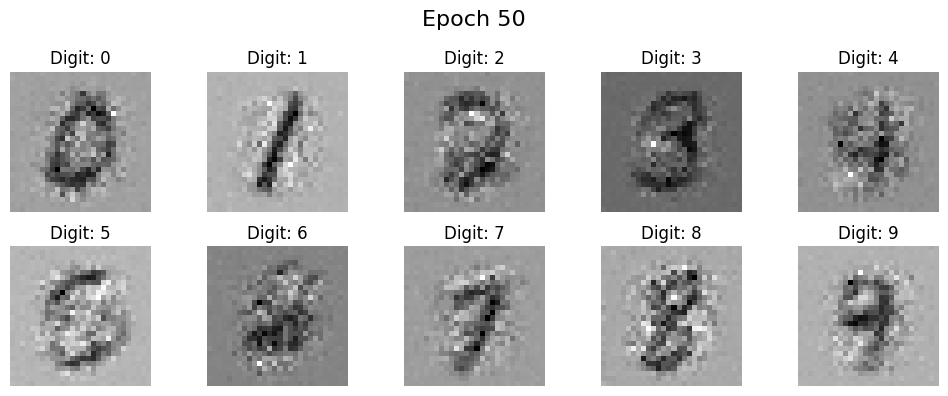

100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Epoch 51/100 | Mean NLL (Loss): -3200.3955


100%|██████████| 469/469 [00:25<00:00, 18.71it/s]


Epoch 52/100 | Mean NLL (Loss): -3204.8248


100%|██████████| 469/469 [00:25<00:00, 18.43it/s]


Epoch 53/100 | Mean NLL (Loss): -3207.6154


100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 54/100 | Mean NLL (Loss): -3210.8715


100%|██████████| 469/469 [00:26<00:00, 17.48it/s]


Epoch 55/100 | Mean NLL (Loss): -3214.4459


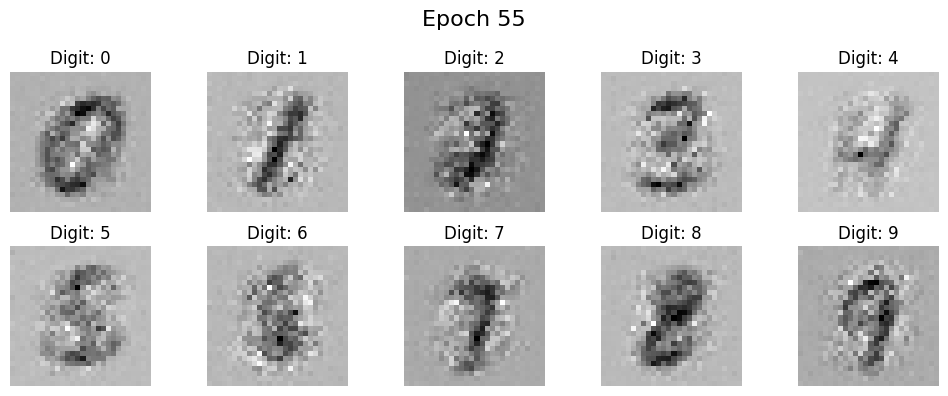

100%|██████████| 469/469 [00:16<00:00, 28.70it/s]


Epoch 56/100 | Mean NLL (Loss): -3216.8801


100%|██████████| 469/469 [00:25<00:00, 18.61it/s]


Epoch 57/100 | Mean NLL (Loss): -3220.3841


100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 58/100 | Mean NLL (Loss): -3223.1924


100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Epoch 59/100 | Mean NLL (Loss): -3225.6871


100%|██████████| 469/469 [00:26<00:00, 17.99it/s]


Epoch 60/100 | Mean NLL (Loss): -3228.6748


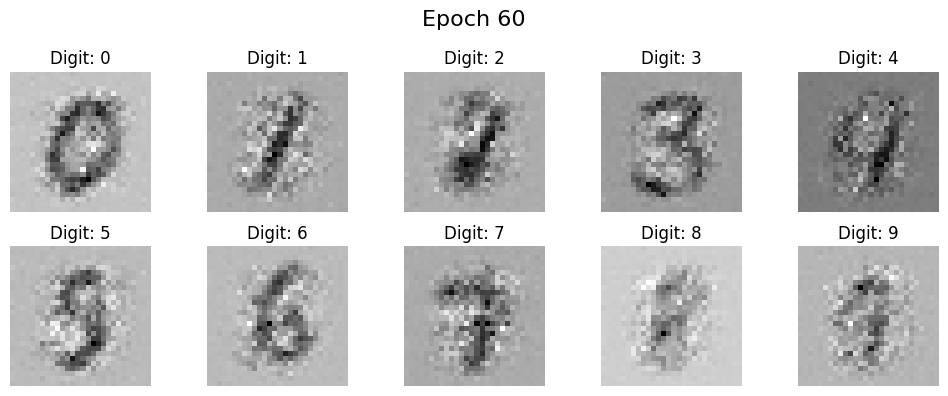

100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Epoch 61/100 | Mean NLL (Loss): -3237.1715


100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Epoch 62/100 | Mean NLL (Loss): -3239.2328


100%|██████████| 469/469 [00:25<00:00, 18.08it/s]


Epoch 63/100 | Mean NLL (Loss): -3241.1473


100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Epoch 64/100 | Mean NLL (Loss): -3242.9101


100%|██████████| 469/469 [00:24<00:00, 18.78it/s]


Epoch 65/100 | Mean NLL (Loss): -3244.8919


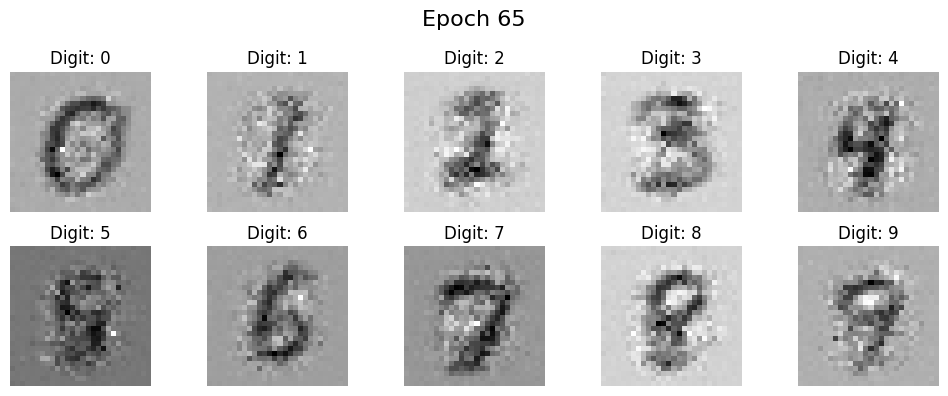

100%|██████████| 469/469 [00:24<00:00, 19.30it/s]


Epoch 66/100 | Mean NLL (Loss): -3246.7488


100%|██████████| 469/469 [00:24<00:00, 18.77it/s]


Epoch 67/100 | Mean NLL (Loss): -3248.5203


100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 68/100 | Mean NLL (Loss): -3250.1960


100%|██████████| 469/469 [00:24<00:00, 19.02it/s]


Epoch 69/100 | Mean NLL (Loss): -3252.1468


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Epoch 70/100 | Mean NLL (Loss): -3253.8723


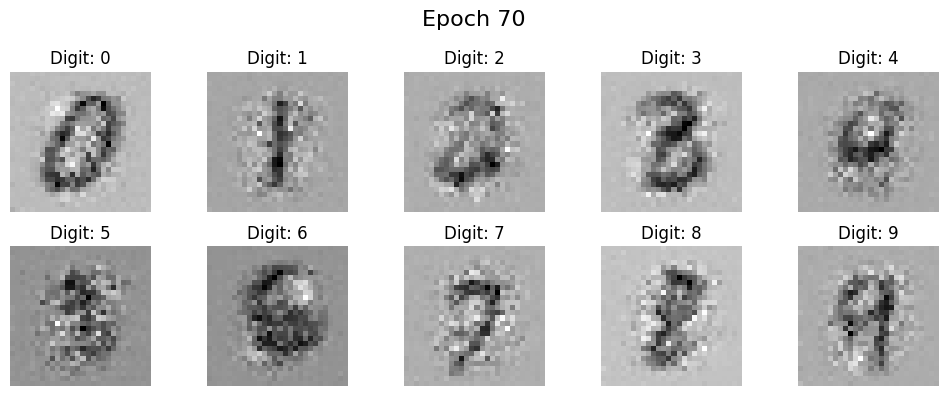

100%|██████████| 469/469 [00:24<00:00, 19.24it/s]


Epoch 71/100 | Mean NLL (Loss): -3256.8599


100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Epoch 72/100 | Mean NLL (Loss): -3257.9909


100%|██████████| 469/469 [00:24<00:00, 19.06it/s]


Epoch 73/100 | Mean NLL (Loss): -3259.0260


100%|██████████| 469/469 [00:24<00:00, 19.10it/s]


Epoch 74/100 | Mean NLL (Loss): -3260.0396


100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Epoch 75/100 | Mean NLL (Loss): -3261.0532


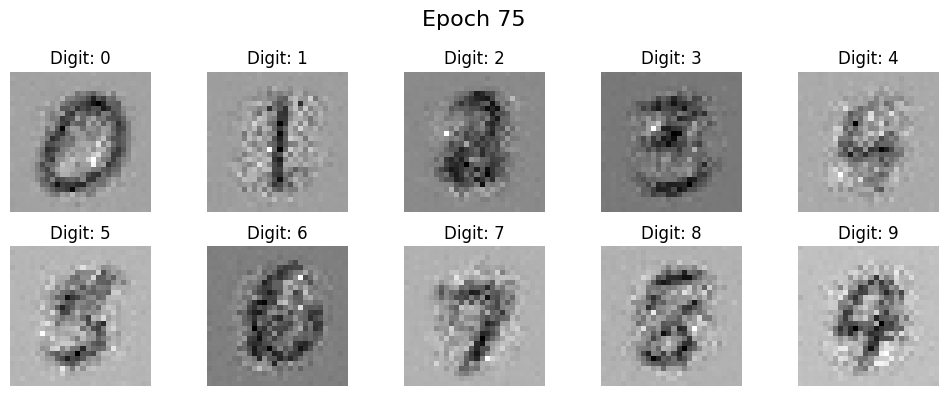

100%|██████████| 469/469 [00:13<00:00, 35.63it/s]


Epoch 76/100 | Mean NLL (Loss): -3262.1327


100%|██████████| 469/469 [00:13<00:00, 34.26it/s]


Epoch 77/100 | Mean NLL (Loss): -3263.2095


100%|██████████| 469/469 [00:12<00:00, 36.58it/s]


Epoch 78/100 | Mean NLL (Loss): -3264.2166


100%|██████████| 469/469 [00:13<00:00, 34.87it/s]


Epoch 79/100 | Mean NLL (Loss): -3265.2874


100%|██████████| 469/469 [00:13<00:00, 35.25it/s]


Epoch 80/100 | Mean NLL (Loss): -3266.2722


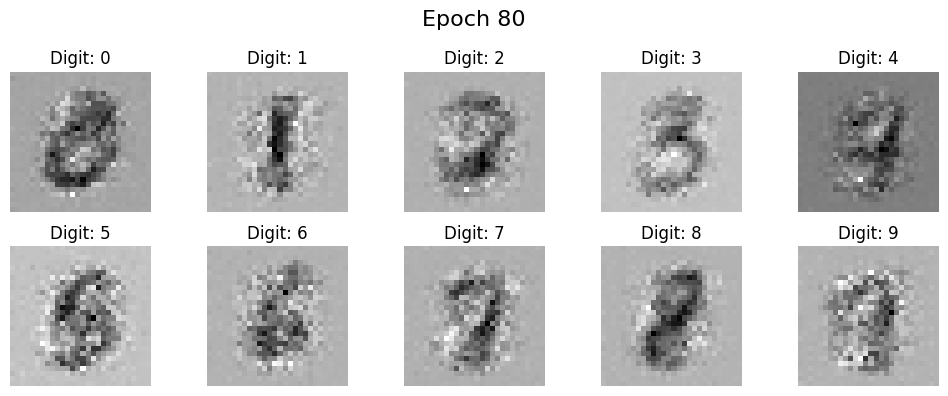

100%|██████████| 469/469 [00:13<00:00, 34.89it/s]


Epoch 81/100 | Mean NLL (Loss): -3267.4548


100%|██████████| 469/469 [00:12<00:00, 37.95it/s]


Epoch 82/100 | Mean NLL (Loss): -3268.0731


100%|██████████| 469/469 [00:12<00:00, 38.70it/s]


Epoch 83/100 | Mean NLL (Loss): -3268.6155


100%|██████████| 469/469 [00:13<00:00, 34.95it/s]


Epoch 84/100 | Mean NLL (Loss): -3269.1940


100%|██████████| 469/469 [00:13<00:00, 34.78it/s]


Epoch 85/100 | Mean NLL (Loss): -3269.7525


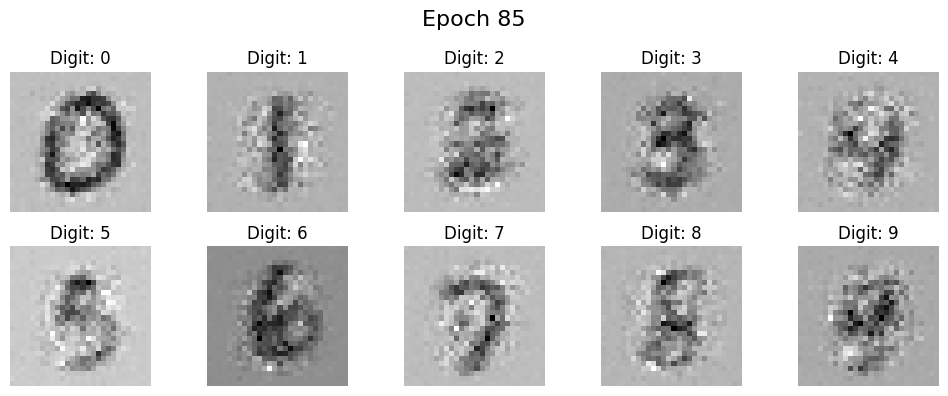

100%|██████████| 469/469 [00:14<00:00, 32.27it/s]


Epoch 86/100 | Mean NLL (Loss): -3270.3235


100%|██████████| 469/469 [00:13<00:00, 34.56it/s]


Epoch 87/100 | Mean NLL (Loss): -3270.9042


100%|██████████| 469/469 [00:12<00:00, 36.19it/s]


Epoch 88/100 | Mean NLL (Loss): -3271.4367


100%|██████████| 469/469 [00:12<00:00, 37.73it/s]


Epoch 89/100 | Mean NLL (Loss): -3272.0236


100%|██████████| 469/469 [00:12<00:00, 38.25it/s]


Epoch 90/100 | Mean NLL (Loss): -3272.5997


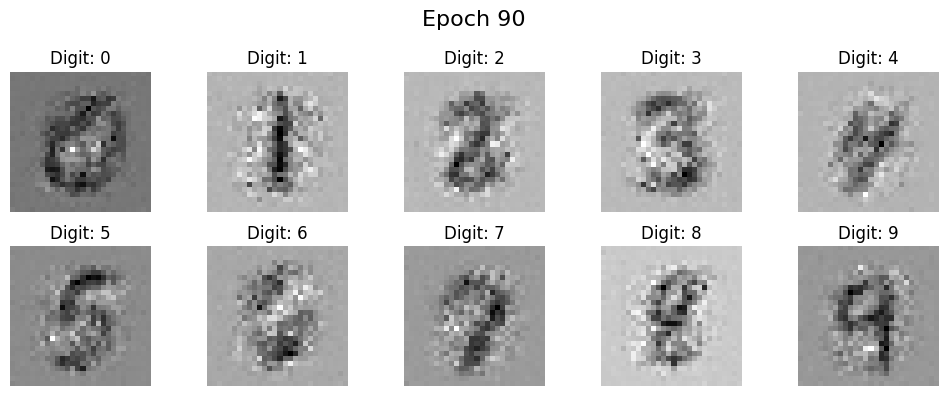

100%|██████████| 469/469 [00:13<00:00, 35.68it/s]


Epoch 91/100 | Mean NLL (Loss): -3273.1108


100%|██████████| 469/469 [00:12<00:00, 37.21it/s]


Epoch 92/100 | Mean NLL (Loss): -3273.4579


100%|██████████| 469/469 [00:12<00:00, 38.62it/s]


Epoch 93/100 | Mean NLL (Loss): -3273.7371


100%|██████████| 469/469 [00:12<00:00, 38.30it/s]


Epoch 94/100 | Mean NLL (Loss): -3274.0348


100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Epoch 95/100 | Mean NLL (Loss): -3274.3395


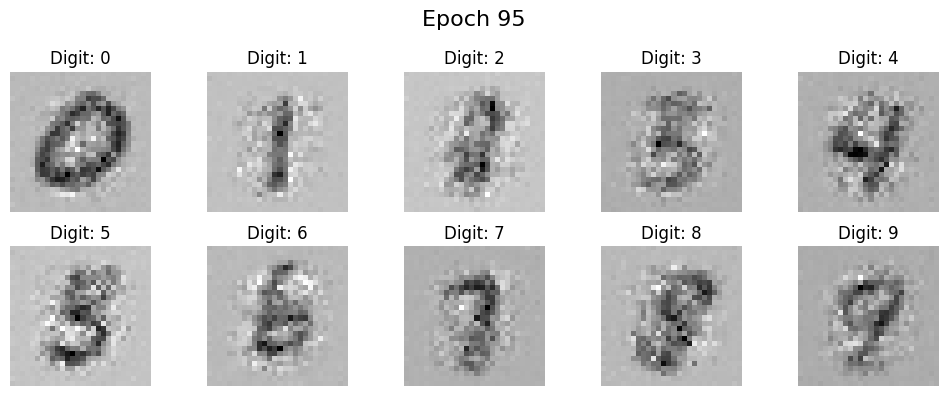

100%|██████████| 469/469 [00:23<00:00, 19.97it/s]


Epoch 96/100 | Mean NLL (Loss): -3274.6287


100%|██████████| 469/469 [00:16<00:00, 28.25it/s]


Epoch 97/100 | Mean NLL (Loss): -3274.9550


100%|██████████| 469/469 [00:12<00:00, 38.31it/s]


Epoch 98/100 | Mean NLL (Loss): -3275.2184


100%|██████████| 469/469 [00:12<00:00, 39.07it/s]


Epoch 99/100 | Mean NLL (Loss): -3275.5431


100%|██████████| 469/469 [00:12<00:00, 38.81it/s]


Epoch 100/100 | Mean NLL (Loss): -3275.8027


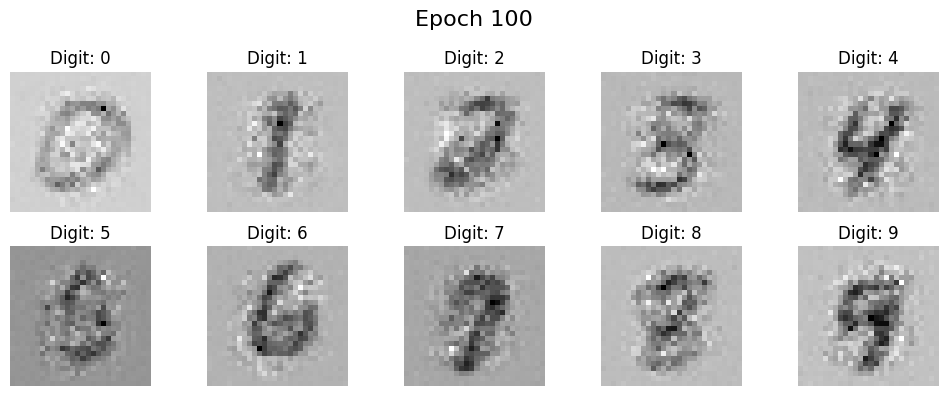

In [12]:
#################################
# TRAINING FOR 5 COUPLING  LAYERS
#################################

# Initialization
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 256      # output size of the hidden layers
num_coupling_layers = 5  # number of coupling layers
num_layers = 5        # number of linear layers for each coupling layer
label_dim = 10

epochs = 100
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

transform_pipeline = transforms.Compose([transforms.ToTensor(),DequantizeAndScale()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = RealNVP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers,
    label_dim= label_dim
).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

losses_5 = train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                         checkpoint_name = 'best_cRealNVP_5.pth')

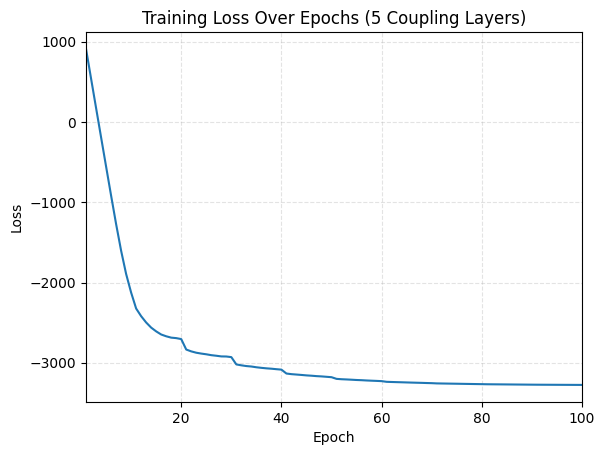

In [13]:
# Plot the Traing Loss over the Epochs
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses_5)
plt.xlim([1, epochs])
plt.grid(True, linestyle='--', alpha=0.35)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (5 Coupling Layers)")
plt.show()
plt.close()

100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 1/150 | Mean NLL (Loss): 924.5887


100%|██████████| 469/469 [00:31<00:00, 14.69it/s]


Epoch 2/150 | Mean NLL (Loss): 545.6733


100%|██████████| 469/469 [00:32<00:00, 14.50it/s]


Epoch 3/150 | Mean NLL (Loss): 179.0157


100%|██████████| 469/469 [00:32<00:00, 14.36it/s]


Epoch 4/150 | Mean NLL (Loss): -187.6349


100%|██████████| 469/469 [00:33<00:00, 14.13it/s]


Epoch 5/150 | Mean NLL (Loss): -554.1576


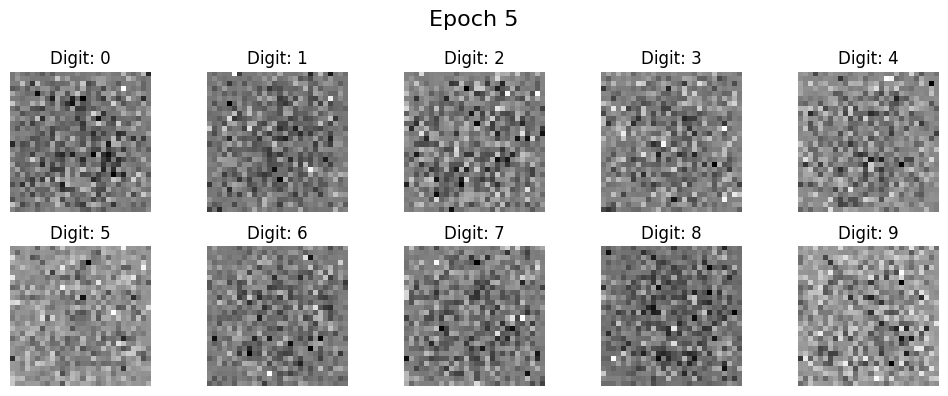

100%|██████████| 469/469 [00:32<00:00, 14.34it/s]


Epoch 6/150 | Mean NLL (Loss): -920.4920


100%|██████████| 469/469 [00:32<00:00, 14.24it/s]


Epoch 7/150 | Mean NLL (Loss): -1286.9569


100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Epoch 8/150 | Mean NLL (Loss): -1649.1809


100%|██████████| 469/469 [00:32<00:00, 14.27it/s]


Epoch 9/150 | Mean NLL (Loss): -1998.3944


100%|██████████| 469/469 [00:32<00:00, 14.61it/s]


Epoch 10/150 | Mean NLL (Loss): -2311.1239


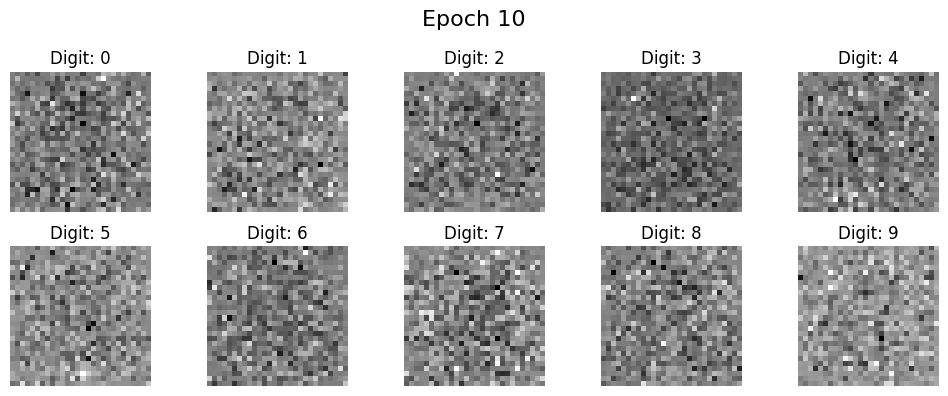

100%|██████████| 469/469 [00:32<00:00, 14.30it/s]


Epoch 11/150 | Mean NLL (Loss): -2598.8458


100%|██████████| 469/469 [00:31<00:00, 14.76it/s]


Epoch 12/150 | Mean NLL (Loss): -2751.4085


100%|██████████| 469/469 [00:25<00:00, 18.36it/s]


Epoch 13/150 | Mean NLL (Loss): -2876.3037


100%|██████████| 469/469 [00:17<00:00, 26.06it/s]


Epoch 14/150 | Mean NLL (Loss): -2982.5099


100%|██████████| 469/469 [00:18<00:00, 25.81it/s]


Epoch 15/150 | Mean NLL (Loss): -3068.2953


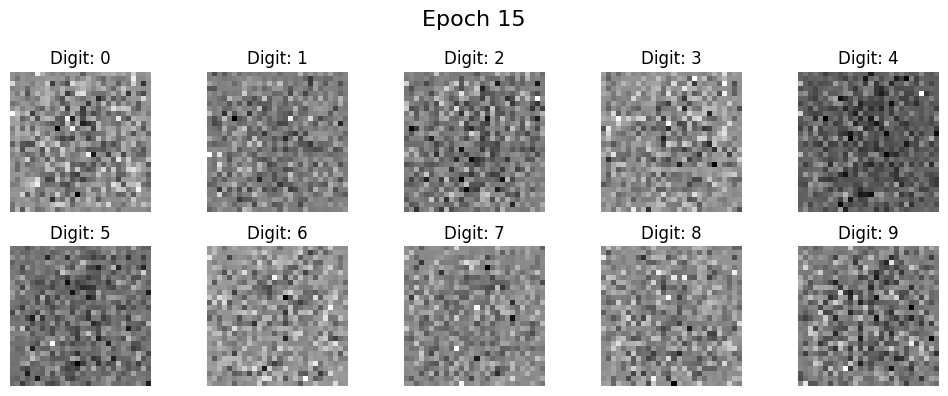

100%|██████████| 469/469 [00:18<00:00, 25.50it/s]


Epoch 16/150 | Mean NLL (Loss): -3122.0135


100%|██████████| 469/469 [00:19<00:00, 24.67it/s]


Epoch 17/150 | Mean NLL (Loss): -3167.9285


100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 18/150 | Mean NLL (Loss): -3201.2165


100%|██████████| 469/469 [00:35<00:00, 13.07it/s]


Epoch 19/150 | Mean NLL (Loss): -3220.4219


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Epoch 20/150 | Mean NLL (Loss): -3242.7698


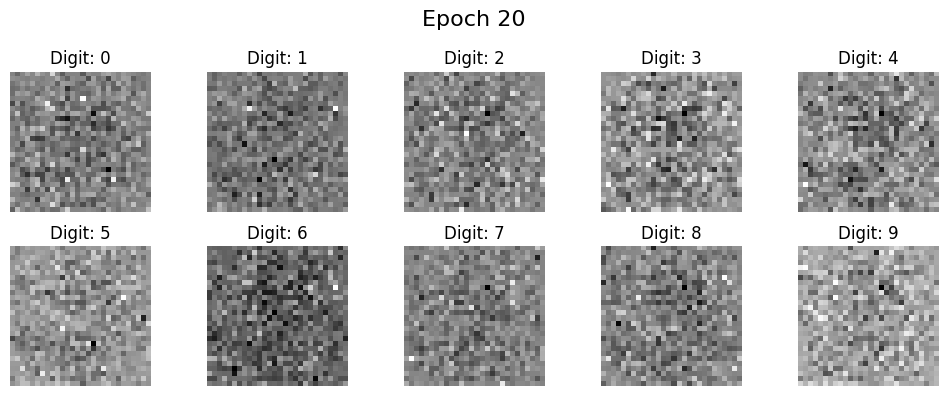

100%|██████████| 469/469 [00:35<00:00, 13.22it/s]


Epoch 21/150 | Mean NLL (Loss): -3460.6446


100%|██████████| 469/469 [00:35<00:00, 13.21it/s]


Epoch 22/150 | Mean NLL (Loss): -3503.0366


100%|██████████| 469/469 [00:35<00:00, 13.22it/s]


Epoch 23/150 | Mean NLL (Loss): -3529.3216


100%|██████████| 469/469 [00:35<00:00, 13.22it/s]


Epoch 24/150 | Mean NLL (Loss): -3553.2412


100%|██████████| 469/469 [00:35<00:00, 13.24it/s]


Epoch 25/150 | Mean NLL (Loss): -3578.0521


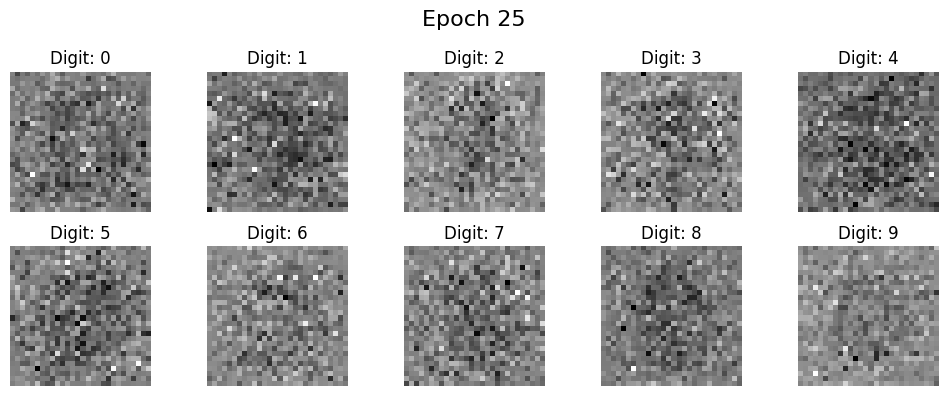

100%|██████████| 469/469 [00:35<00:00, 13.19it/s]


Epoch 26/150 | Mean NLL (Loss): -3592.0600


100%|██████████| 469/469 [00:35<00:00, 13.32it/s]


Epoch 27/150 | Mean NLL (Loss): -3604.7946


100%|██████████| 469/469 [00:35<00:00, 13.40it/s]


Epoch 28/150 | Mean NLL (Loss): -3620.4918


100%|██████████| 469/469 [00:35<00:00, 13.38it/s]


Epoch 29/150 | Mean NLL (Loss): -3632.0058


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


Epoch 30/150 | Mean NLL (Loss): -3641.4155


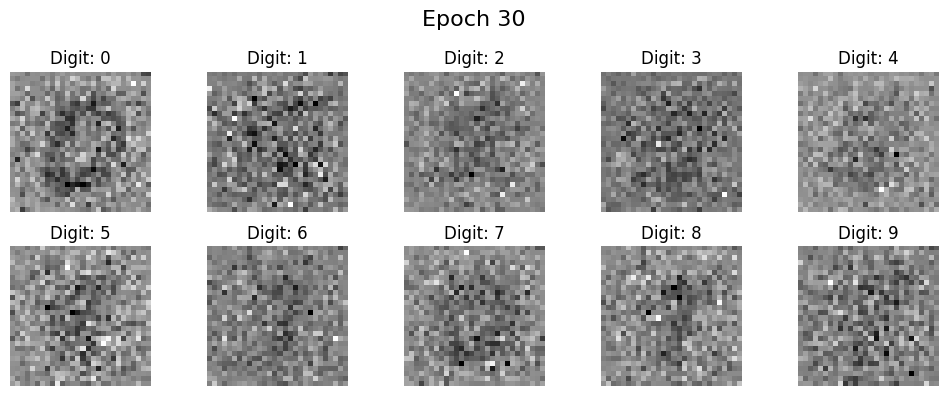

100%|██████████| 469/469 [00:34<00:00, 13.58it/s]


Epoch 31/150 | Mean NLL (Loss): -3788.4586


100%|██████████| 469/469 [00:34<00:00, 13.55it/s]


Epoch 32/150 | Mean NLL (Loss): -3809.2330


100%|██████████| 469/469 [00:34<00:00, 13.55it/s]


Epoch 33/150 | Mean NLL (Loss): -3823.7572


100%|██████████| 469/469 [00:34<00:00, 13.60it/s]


Epoch 34/150 | Mean NLL (Loss): -3838.0042


100%|██████████| 469/469 [00:34<00:00, 13.47it/s]


Epoch 35/150 | Mean NLL (Loss): -3851.2852


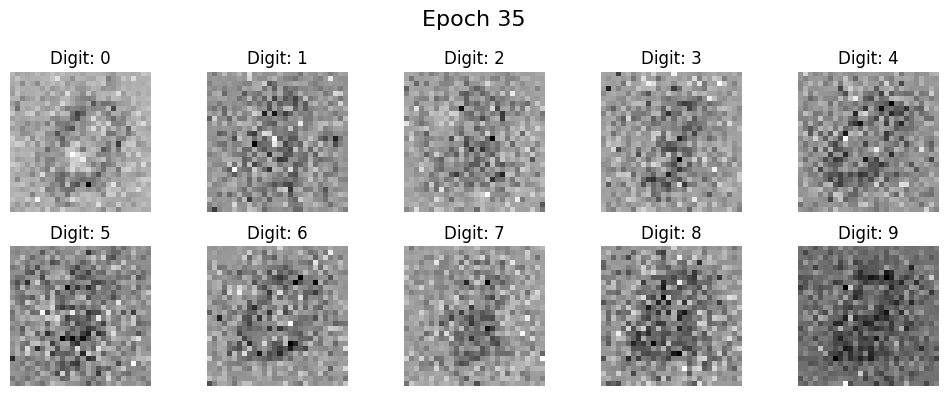

100%|██████████| 469/469 [00:34<00:00, 13.49it/s]


Epoch 36/150 | Mean NLL (Loss): -3861.3139


100%|██████████| 469/469 [00:34<00:00, 13.64it/s]


Epoch 37/150 | Mean NLL (Loss): -3873.2025


100%|██████████| 469/469 [00:34<00:00, 13.54it/s]


Epoch 38/150 | Mean NLL (Loss): -3884.3973


100%|██████████| 469/469 [00:33<00:00, 13.86it/s]


Epoch 39/150 | Mean NLL (Loss): -3894.6100


100%|██████████| 469/469 [00:34<00:00, 13.51it/s]


Epoch 40/150 | Mean NLL (Loss): -3906.4163


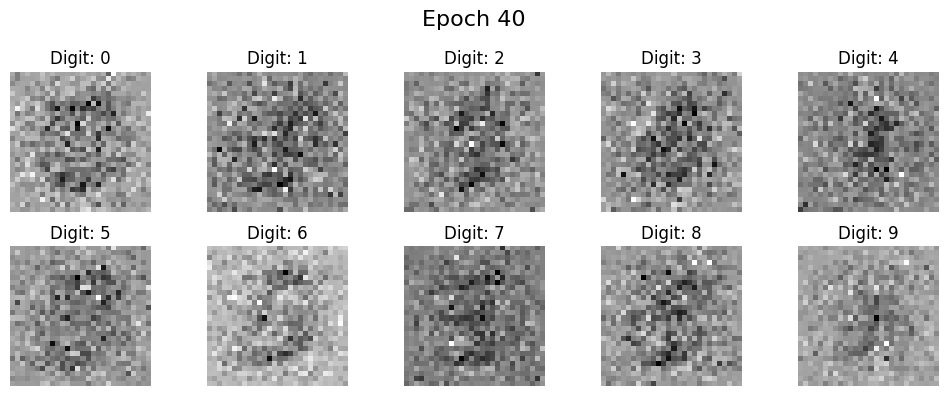

100%|██████████| 469/469 [00:34<00:00, 13.65it/s]


Epoch 41/150 | Mean NLL (Loss): -3977.5517


100%|██████████| 469/469 [00:31<00:00, 15.11it/s]


Epoch 42/150 | Mean NLL (Loss): -3990.0433


100%|██████████| 469/469 [00:30<00:00, 15.34it/s]


Epoch 43/150 | Mean NLL (Loss): -3997.3211


100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Epoch 44/150 | Mean NLL (Loss): -4006.4181


100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Epoch 45/150 | Mean NLL (Loss): -4015.9915


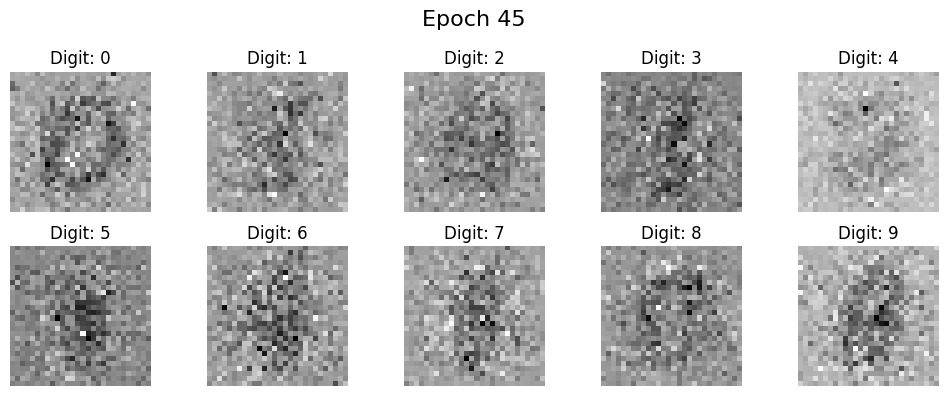

100%|██████████| 469/469 [00:32<00:00, 14.34it/s]


Epoch 46/150 | Mean NLL (Loss): -4024.1372


100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Epoch 47/150 | Mean NLL (Loss): -4031.1686


100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Epoch 48/150 | Mean NLL (Loss): -4039.5563


100%|██████████| 469/469 [00:32<00:00, 14.44it/s]


Epoch 49/150 | Mean NLL (Loss): -4047.9365


100%|██████████| 469/469 [00:32<00:00, 14.25it/s]


Epoch 50/150 | Mean NLL (Loss): -4055.1782


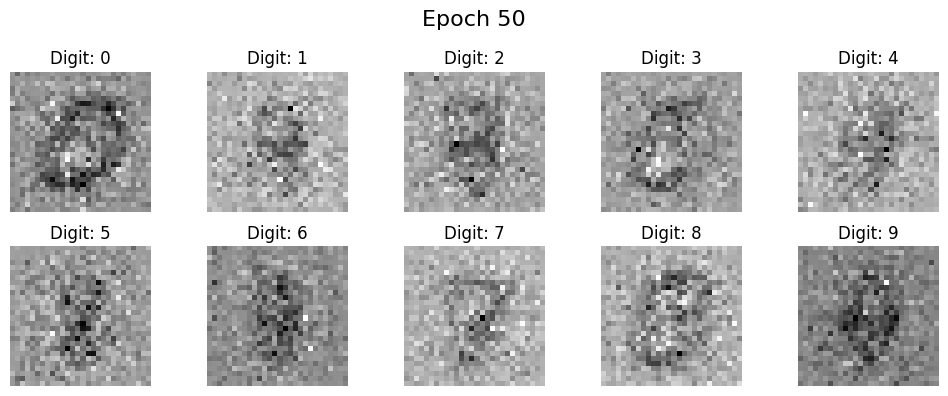

100%|██████████| 469/469 [00:32<00:00, 14.23it/s]


Epoch 51/150 | Mean NLL (Loss): -4085.7618


100%|██████████| 469/469 [00:32<00:00, 14.44it/s]


Epoch 52/150 | Mean NLL (Loss): -4092.1112


100%|██████████| 469/469 [00:32<00:00, 14.51it/s]


Epoch 53/150 | Mean NLL (Loss): -4097.6371


100%|██████████| 469/469 [00:32<00:00, 14.61it/s]


Epoch 54/150 | Mean NLL (Loss): -4103.1362


100%|██████████| 469/469 [00:33<00:00, 14.10it/s]


Epoch 55/150 | Mean NLL (Loss): -4108.4036


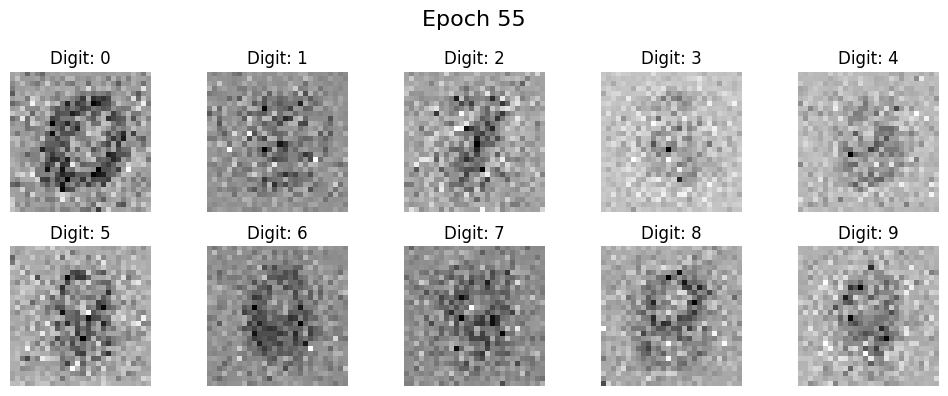

100%|██████████| 469/469 [00:24<00:00, 19.02it/s]


Epoch 56/150 | Mean NLL (Loss): -4113.3827


100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Epoch 57/150 | Mean NLL (Loss): -4118.9886


100%|██████████| 469/469 [00:18<00:00, 25.75it/s]


Epoch 58/150 | Mean NLL (Loss): -4123.9814


100%|██████████| 469/469 [00:18<00:00, 25.84it/s]


Epoch 59/150 | Mean NLL (Loss): -4129.3738


100%|██████████| 469/469 [00:18<00:00, 25.50it/s]


Epoch 60/150 | Mean NLL (Loss): -4134.3019


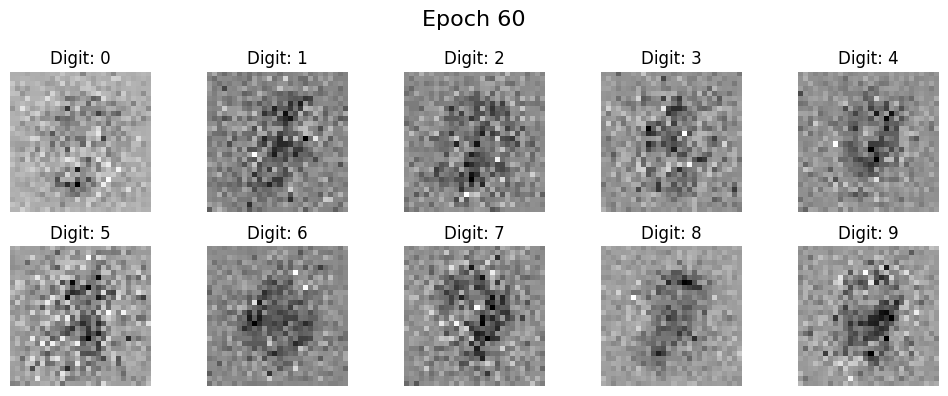

100%|██████████| 469/469 [00:18<00:00, 25.56it/s]


Epoch 61/150 | Mean NLL (Loss): -4145.8156


100%|██████████| 469/469 [00:18<00:00, 25.52it/s]


Epoch 62/150 | Mean NLL (Loss): -4149.6350


100%|██████████| 469/469 [00:18<00:00, 25.61it/s]


Epoch 63/150 | Mean NLL (Loss): -4152.7821


100%|██████████| 469/469 [00:17<00:00, 26.32it/s]


Epoch 64/150 | Mean NLL (Loss): -4156.0818


100%|██████████| 469/469 [00:17<00:00, 26.57it/s]


Epoch 65/150 | Mean NLL (Loss): -4159.4314


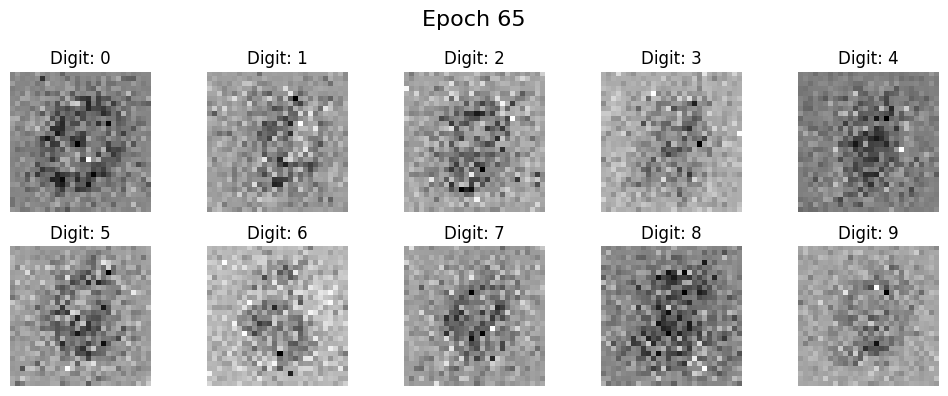

100%|██████████| 469/469 [00:17<00:00, 26.47it/s]


Epoch 66/150 | Mean NLL (Loss): -4162.6427


100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Epoch 67/150 | Mean NLL (Loss): -4166.0035


100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Epoch 68/150 | Mean NLL (Loss): -4169.2419


100%|██████████| 469/469 [00:18<00:00, 26.01it/s]


Epoch 69/150 | Mean NLL (Loss): -4172.4816


100%|██████████| 469/469 [00:18<00:00, 25.99it/s]


Epoch 70/150 | Mean NLL (Loss): -4175.8840


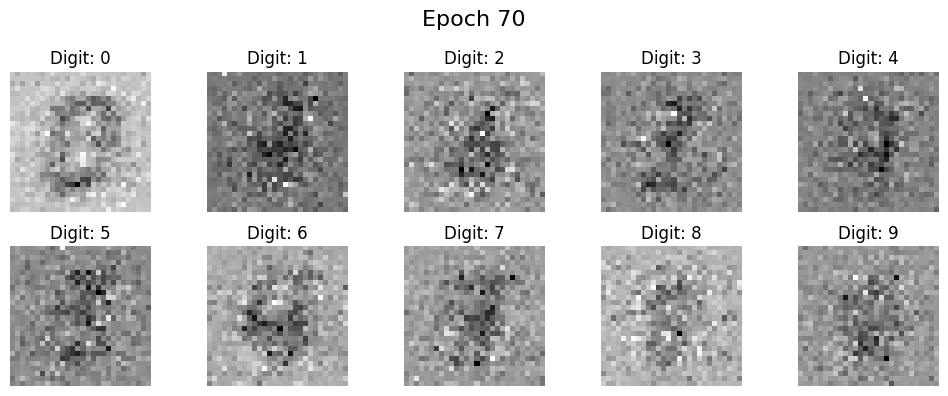

100%|██████████| 469/469 [00:19<00:00, 24.64it/s]


Epoch 71/150 | Mean NLL (Loss): -4180.3645


100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


Epoch 72/150 | Mean NLL (Loss): -4182.4325


100%|██████████| 469/469 [00:36<00:00, 12.81it/s]


Epoch 73/150 | Mean NLL (Loss): -4184.3736


100%|██████████| 469/469 [00:35<00:00, 13.13it/s]


Epoch 74/150 | Mean NLL (Loss): -4186.3347


100%|██████████| 469/469 [00:35<00:00, 13.06it/s]


Epoch 75/150 | Mean NLL (Loss): -4188.2580


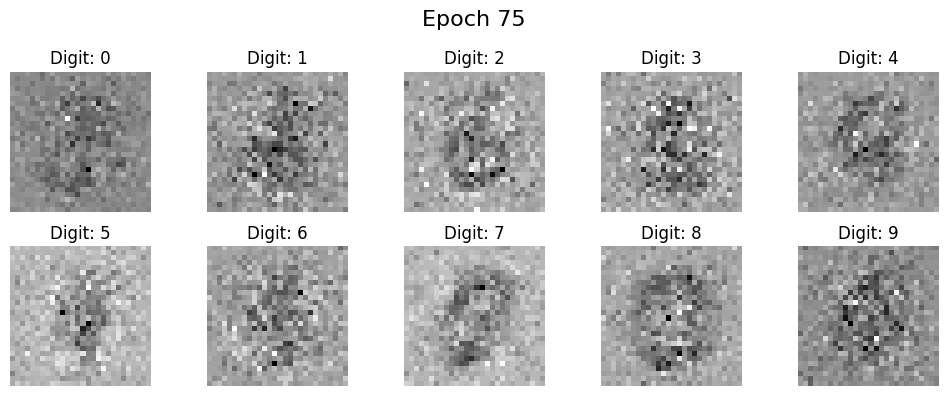

100%|██████████| 469/469 [00:35<00:00, 13.11it/s]


Epoch 76/150 | Mean NLL (Loss): -4190.1816


100%|██████████| 469/469 [00:35<00:00, 13.25it/s]


Epoch 77/150 | Mean NLL (Loss): -4192.0925


100%|██████████| 469/469 [00:35<00:00, 13.14it/s]


Epoch 78/150 | Mean NLL (Loss): -4194.0487


100%|██████████| 469/469 [00:35<00:00, 13.21it/s]


Epoch 79/150 | Mean NLL (Loss): -4195.9572


100%|██████████| 469/469 [00:35<00:00, 13.19it/s]


Epoch 80/150 | Mean NLL (Loss): -4197.8061


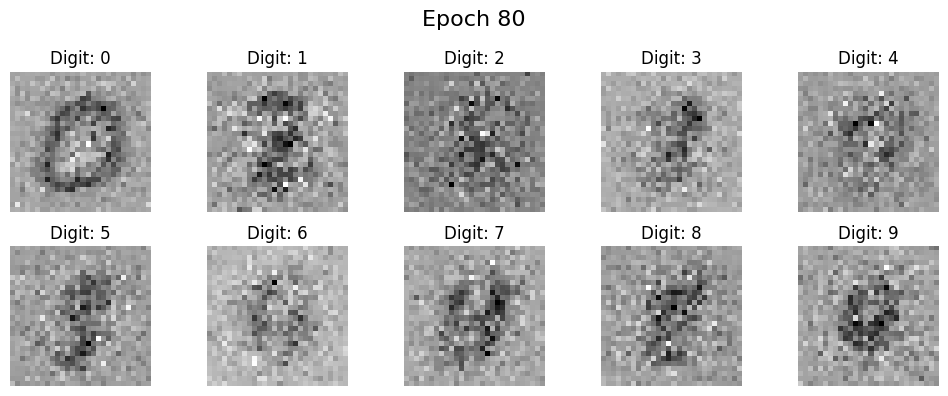

100%|██████████| 469/469 [00:35<00:00, 13.28it/s]


Epoch 81/150 | Mean NLL (Loss): -4199.8622


100%|██████████| 469/469 [00:35<00:00, 13.18it/s]


Epoch 82/150 | Mean NLL (Loss): -4200.9243


100%|██████████| 469/469 [00:35<00:00, 13.19it/s]


Epoch 83/150 | Mean NLL (Loss): -4201.9472


100%|██████████| 469/469 [00:30<00:00, 15.30it/s]


Epoch 84/150 | Mean NLL (Loss): -4202.9871


100%|██████████| 469/469 [00:17<00:00, 26.28it/s]


Epoch 85/150 | Mean NLL (Loss): -4204.0339


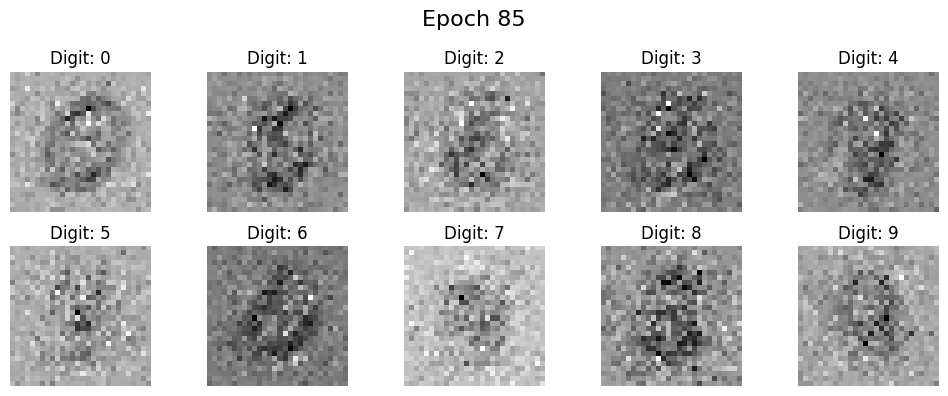

100%|██████████| 469/469 [00:17<00:00, 26.10it/s]


Epoch 86/150 | Mean NLL (Loss): -4205.0512


100%|██████████| 469/469 [00:18<00:00, 25.85it/s]


Epoch 87/150 | Mean NLL (Loss): -4206.0913


100%|██████████| 469/469 [00:18<00:00, 25.78it/s]


Epoch 88/150 | Mean NLL (Loss): -4207.1090


100%|██████████| 469/469 [00:18<00:00, 25.49it/s]


Epoch 89/150 | Mean NLL (Loss): -4208.1322


100%|██████████| 469/469 [00:18<00:00, 25.37it/s]


Epoch 90/150 | Mean NLL (Loss): -4209.1547


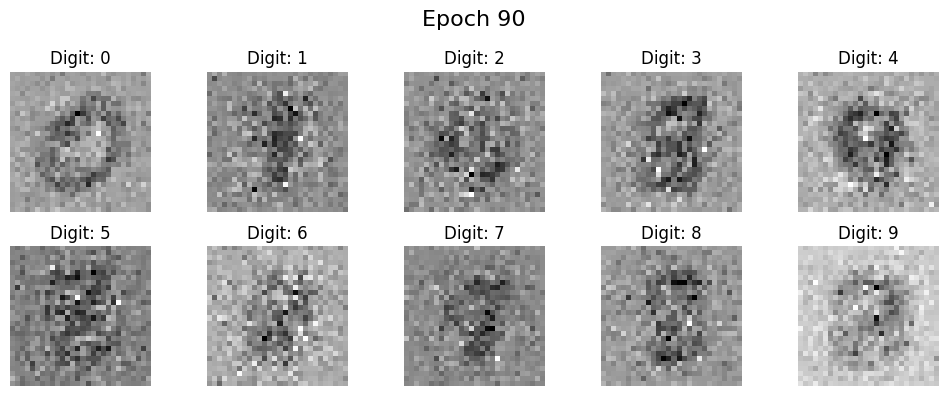

100%|██████████| 469/469 [00:17<00:00, 26.24it/s]


Epoch 91/150 | Mean NLL (Loss): -4210.0732


100%|██████████| 469/469 [00:17<00:00, 26.29it/s]


Epoch 92/150 | Mean NLL (Loss): -4210.6145


100%|██████████| 469/469 [00:17<00:00, 26.74it/s]


Epoch 93/150 | Mean NLL (Loss): -4211.1543


100%|██████████| 469/469 [00:17<00:00, 26.13it/s]


Epoch 94/150 | Mean NLL (Loss): -4211.6898


100%|██████████| 469/469 [00:17<00:00, 26.14it/s]


Epoch 95/150 | Mean NLL (Loss): -4212.2154


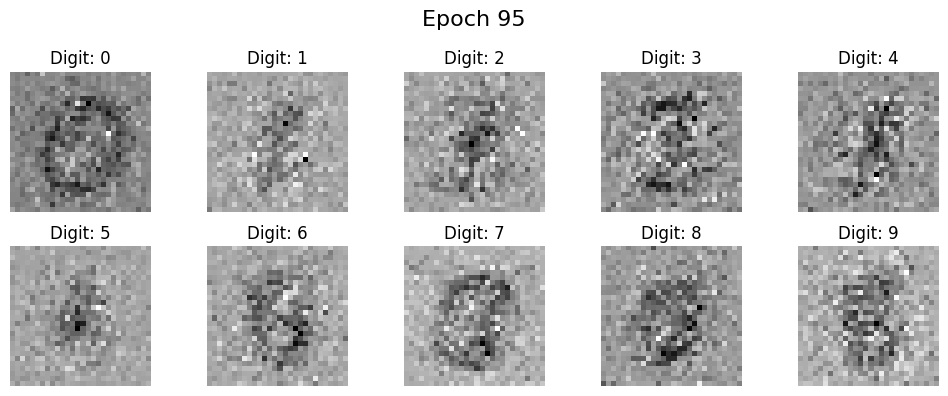

100%|██████████| 469/469 [00:18<00:00, 26.00it/s]


Epoch 96/150 | Mean NLL (Loss): -4212.7498


100%|██████████| 469/469 [00:18<00:00, 25.77it/s]


Epoch 97/150 | Mean NLL (Loss): -4213.2871


100%|██████████| 469/469 [00:18<00:00, 24.74it/s]


Epoch 98/150 | Mean NLL (Loss): -4213.8182


100%|██████████| 469/469 [00:18<00:00, 25.16it/s]


Epoch 99/150 | Mean NLL (Loss): -4214.3420


100%|██████████| 469/469 [00:18<00:00, 24.70it/s]


Epoch 100/150 | Mean NLL (Loss): -4214.8740


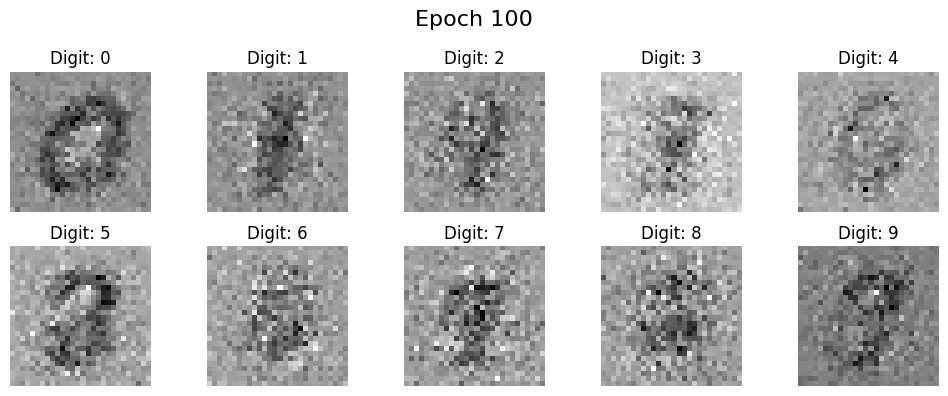

100%|██████████| 469/469 [00:18<00:00, 25.38it/s]


Epoch 101/150 | Mean NLL (Loss): -4215.3136


100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 102/150 | Mean NLL (Loss): -4215.5955


100%|██████████| 469/469 [00:18<00:00, 25.24it/s]


Epoch 103/150 | Mean NLL (Loss): -4215.8719


100%|██████████| 469/469 [00:17<00:00, 26.59it/s]


Epoch 104/150 | Mean NLL (Loss): -4216.1367


100%|██████████| 469/469 [00:17<00:00, 26.22it/s]


Epoch 105/150 | Mean NLL (Loss): -4216.4060


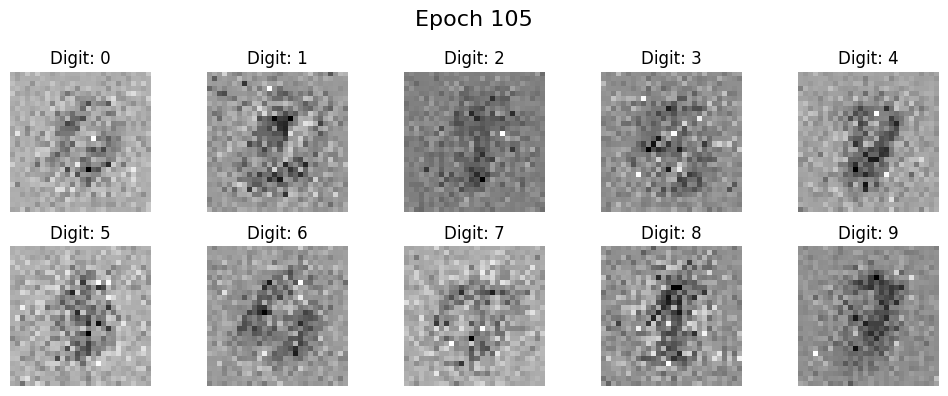

100%|██████████| 469/469 [00:17<00:00, 26.33it/s]


Epoch 106/150 | Mean NLL (Loss): -4216.6767


100%|██████████| 469/469 [00:18<00:00, 25.56it/s]


Epoch 107/150 | Mean NLL (Loss): -4216.9579


100%|██████████| 469/469 [00:18<00:00, 25.72it/s]


Epoch 108/150 | Mean NLL (Loss): -4217.2324


100%|██████████| 469/469 [00:18<00:00, 25.83it/s]


Epoch 109/150 | Mean NLL (Loss): -4217.5074


100%|██████████| 469/469 [00:18<00:00, 25.67it/s]


Epoch 110/150 | Mean NLL (Loss): -4217.7762


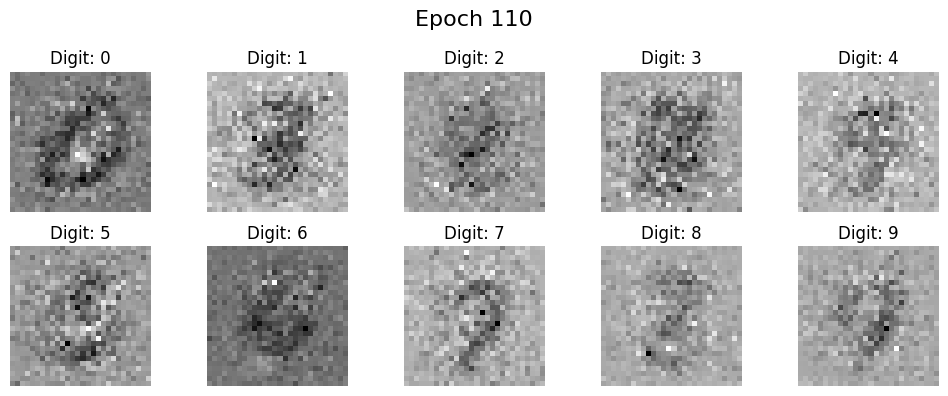

100%|██████████| 469/469 [00:18<00:00, 25.11it/s]


Epoch 111/150 | Mean NLL (Loss): -4217.9946


100%|██████████| 469/469 [00:18<00:00, 25.16it/s]


Epoch 112/150 | Mean NLL (Loss): -4218.1330


100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Epoch 113/150 | Mean NLL (Loss): -4218.2746


100%|██████████| 469/469 [00:18<00:00, 25.11it/s]


Epoch 114/150 | Mean NLL (Loss): -4218.4138


100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


Epoch 115/150 | Mean NLL (Loss): -4218.5536


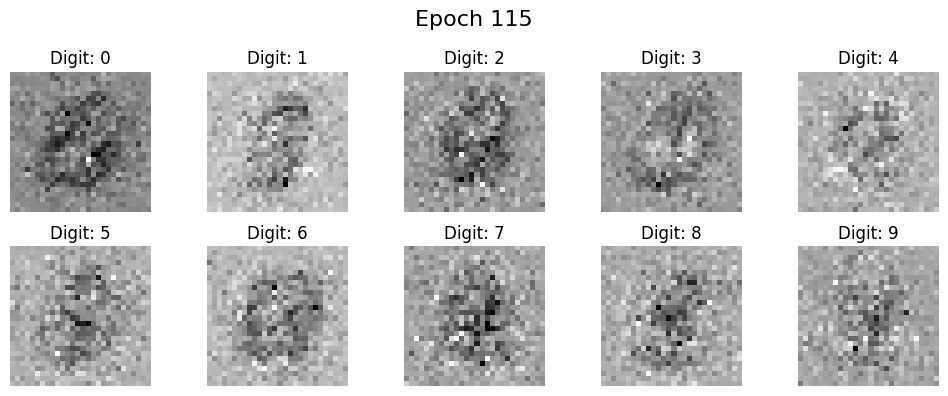

100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Epoch 116/150 | Mean NLL (Loss): -4218.6902


100%|██████████| 469/469 [00:35<00:00, 13.13it/s]


Epoch 117/150 | Mean NLL (Loss): -4218.8357


100%|██████████| 469/469 [00:35<00:00, 13.26it/s]


Epoch 118/150 | Mean NLL (Loss): -4218.9693


100%|██████████| 469/469 [00:35<00:00, 13.25it/s]


Epoch 119/150 | Mean NLL (Loss): -4219.1082


100%|██████████| 469/469 [00:35<00:00, 13.20it/s]


Epoch 120/150 | Mean NLL (Loss): -4219.2511


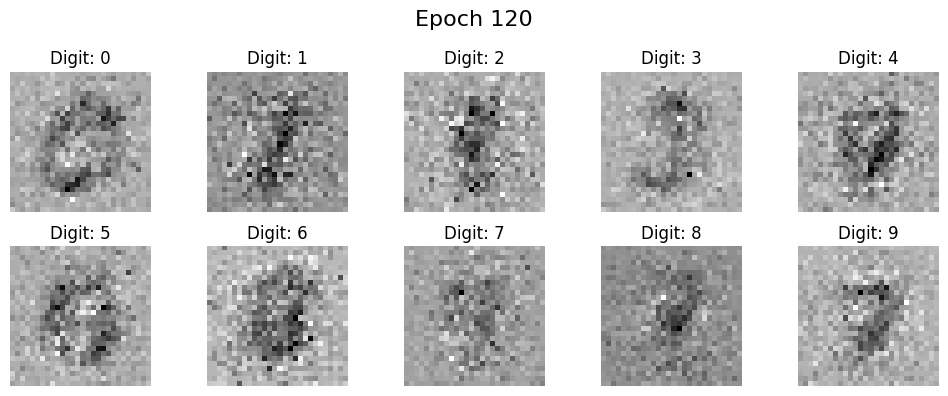

100%|██████████| 469/469 [00:35<00:00, 13.18it/s]


Epoch 121/150 | Mean NLL (Loss): -4219.3443


100%|██████████| 469/469 [00:35<00:00, 13.29it/s]


Epoch 122/150 | Mean NLL (Loss): -4219.3851


100%|██████████| 469/469 [00:35<00:00, 13.27it/s]


Epoch 123/150 | Mean NLL (Loss): -4219.4285


100%|██████████| 469/469 [00:35<00:00, 13.25it/s]


Epoch 124/150 | Mean NLL (Loss): -4219.4556


100%|██████████| 469/469 [00:32<00:00, 14.57it/s]


Epoch 125/150 | Mean NLL (Loss): -4219.4965


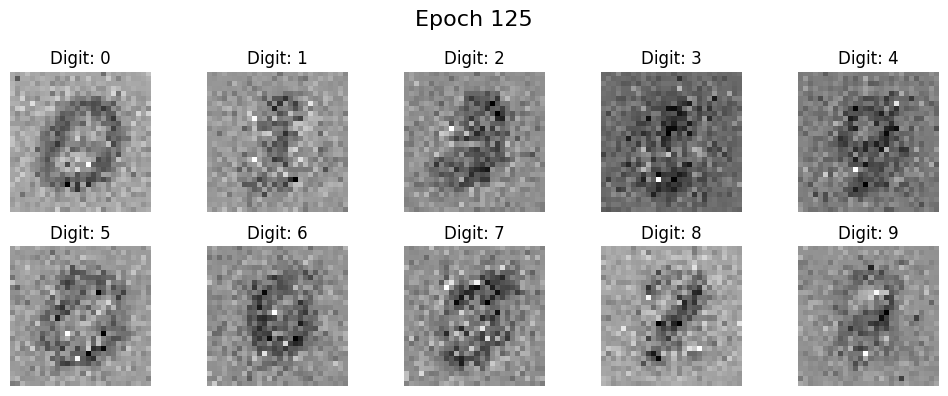

100%|██████████| 469/469 [00:18<00:00, 26.04it/s]


Epoch 126/150 | Mean NLL (Loss): -4219.5290


100%|██████████| 469/469 [00:18<00:00, 25.73it/s]


Epoch 127/150 | Mean NLL (Loss): -4219.5663


100%|██████████| 469/469 [00:22<00:00, 20.46it/s]


Epoch 128/150 | Mean NLL (Loss): -4219.6066


100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 129/150 | Mean NLL (Loss): -4219.6536


100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


Epoch 130/150 | Mean NLL (Loss): -4219.6829


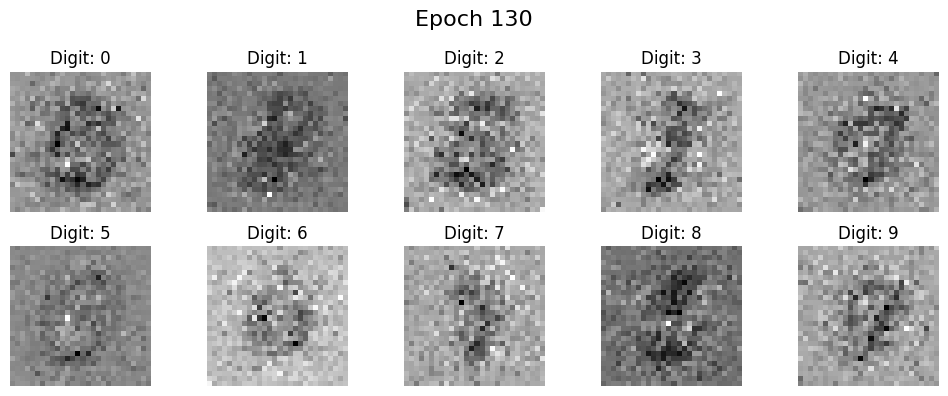

100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Epoch 131/150 | Mean NLL (Loss): -4219.7116


100%|██████████| 469/469 [00:19<00:00, 23.94it/s]


Epoch 132/150 | Mean NLL (Loss): -4219.7204


100%|██████████| 469/469 [00:19<00:00, 23.62it/s]


Epoch 133/150 | Mean NLL (Loss): -4219.7295


100%|██████████| 469/469 [00:19<00:00, 23.88it/s]


Epoch 134/150 | Mean NLL (Loss): -4219.7384


100%|██████████| 469/469 [00:20<00:00, 23.38it/s]


Epoch 135/150 | Mean NLL (Loss): -4219.7407


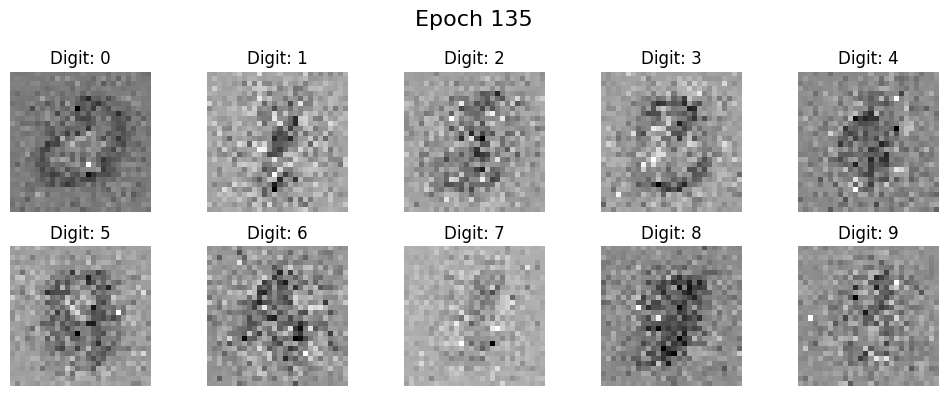

100%|██████████| 469/469 [00:19<00:00, 24.19it/s]


Epoch 136/150 | Mean NLL (Loss): -4219.7513


100%|██████████| 469/469 [00:18<00:00, 25.29it/s]


Epoch 137/150 | Mean NLL (Loss): -4219.7536


100%|██████████| 469/469 [00:18<00:00, 25.06it/s]


Epoch 138/150 | Mean NLL (Loss): -4219.7767


100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Epoch 139/150 | Mean NLL (Loss): -4219.7806


100%|██████████| 469/469 [00:18<00:00, 24.98it/s]


Epoch 140/150 | Mean NLL (Loss): -4219.7876


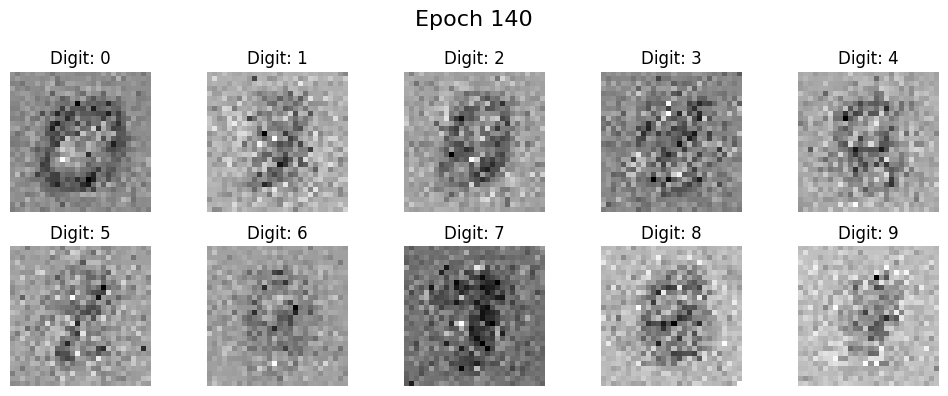

100%|██████████| 469/469 [00:18<00:00, 25.14it/s]


Epoch 141/150 | Mean NLL (Loss): -4219.7960


100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 142/150 | Mean NLL (Loss): -4219.8012


100%|██████████| 469/469 [00:18<00:00, 24.85it/s]


Epoch 143/150 | Mean NLL (Loss): -4219.8044


100%|██████████| 469/469 [00:18<00:00, 25.07it/s]


Epoch 144/150 | Mean NLL (Loss): -4219.8152


100%|██████████| 469/469 [00:18<00:00, 24.82it/s]


Epoch 145/150 | Mean NLL (Loss): -4219.8163


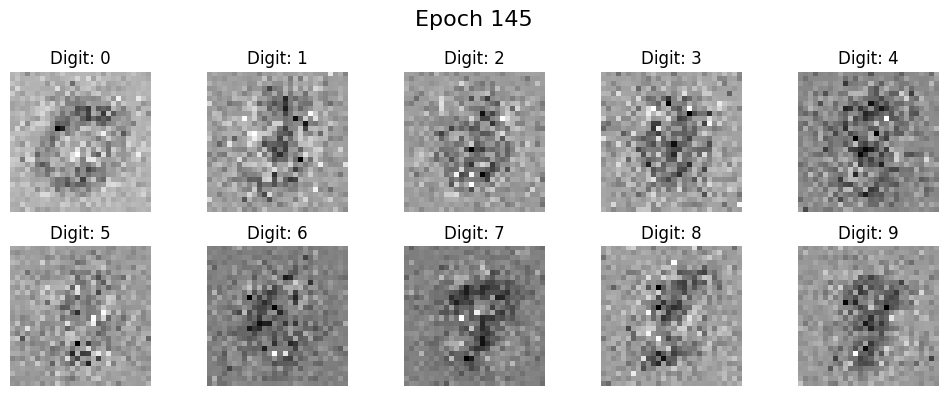

100%|██████████| 469/469 [00:18<00:00, 25.12it/s]


Epoch 146/150 | Mean NLL (Loss): -4219.8207


100%|██████████| 469/469 [00:18<00:00, 25.01it/s]


Epoch 147/150 | Mean NLL (Loss): -4219.8231


100%|██████████| 469/469 [00:18<00:00, 25.04it/s]


Epoch 148/150 | Mean NLL (Loss): -4219.8333


100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Epoch 149/150 | Mean NLL (Loss): -4219.8299


100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 150/150 | Mean NLL (Loss): -4219.8291


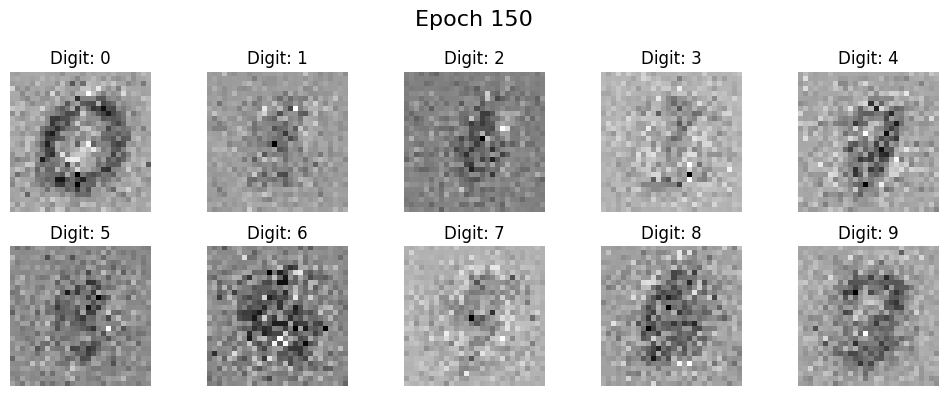

In [19]:
#################################
# TRAINING FOR 10 COUPLING LAYERS
#################################

# Initialization
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 256      # output size of the hidden layers
num_coupling_layers = 10  # number of coupling layers
num_layers = 5       # number of linear layers for each coupling layer
label_dim = 10

epochs = 150
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

transform_pipeline = transforms.Compose([transforms.ToTensor(),DequantizeAndScale()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = RealNVP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers,
    label_dim= label_dim
).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

losses_10 = train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                          checkpoint_name = 'best_cRealNVP_10.pth')

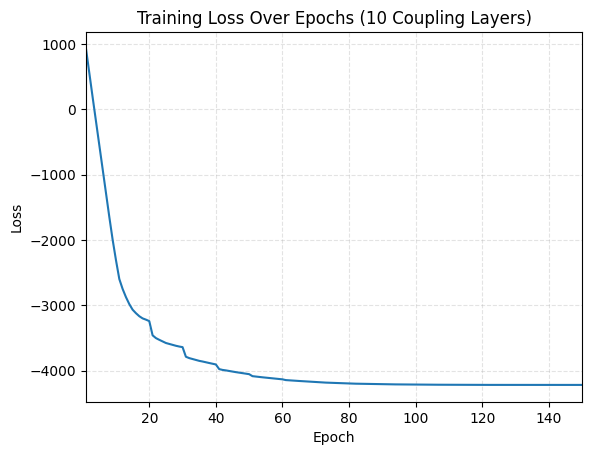

In [20]:
# Plot the Traing Loss over the Epochs
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses_10)
plt.xlim([1, epochs])
plt.grid(True, linestyle='--', alpha=0.35)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (10 Coupling Layers)")
plt.show()
plt.close()

↓ Load Saved Model ↓

Loaded model from epoch 100 with loss -3275.8027


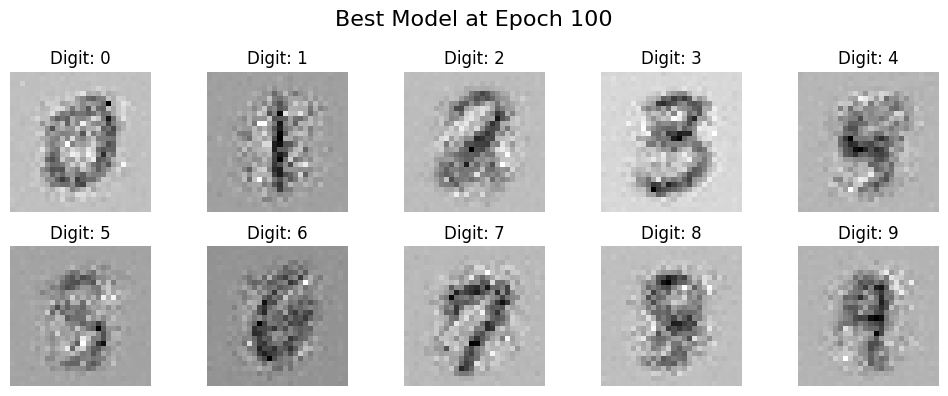

Loaded model from epoch 148 with loss -4219.8333


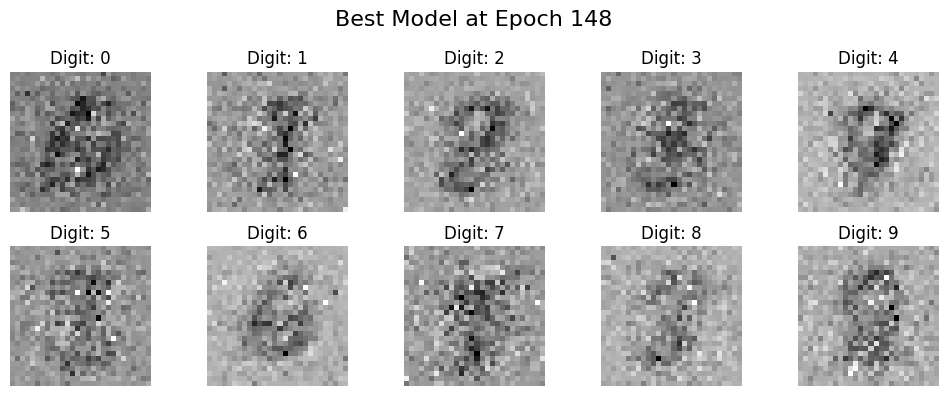

In [21]:
# # LOAD BEST_MODELS FROM CHECKPOINT .pth FILE (5 and 10 coupling layers)
# def load_model(filepath, model, optimizer=None):
#     checkpoint = tc.load(filepath)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     if optimizer:
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
#     print(f"Loaded model from epoch {epoch} with loss {loss:.4f}")
#     return model, optimizer, epoch, loss

# length, height = 28, 28   # input size (MNIST)
# input_dim = length * height
# hidden_dim = 256      # output size of the hidden layers
# num_coupling_layers = 5  # number of coupling layers
# num_layers = 5        # number of linear layers for each coupling layer

# epochs = 150
# batch_size = 128
# betas = (0.9, 0.01)
# eps = 1e-4
# lr = 1e-3

# model = RealNVP(
#     input_dim=input_dim,
#     hidden_dim=hidden_dim,
#     n_coupling_layers=num_coupling_layers,
#     n_layers=num_layers
# ).to(device)

# optimizer = tc.optim.Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
# model, optimizer, epoch, loss = load_model('checkpoints/best_cRealNVP_5.pth', model, optimizer)
# sample_model(model, n_samples=10, title=f"Best Model at Epoch {epoch}")

# num_coupling_layers = 10
# model = RealNVP(
#     input_dim=input_dim,
#     hidden_dim=hidden_dim,
#     n_coupling_layers=num_coupling_layers,
#     n_layers=num_layers
# ).to(device)

# optimizer = tc.optim.Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
# model, optimizer, epoch, loss = load_model('checkpoints/best_cRealNVP_10.pth', model, optimizer)
# sample_model(model, n_samples=10, title=f"Best Model at Epoch {epoch}")